# Testing differential gene module expression between groups of cells

In [2]:
library(ggplot2)
library(ggrepel)
library(plyr)
library(dplyr)
library(Seurat)
library(tidyr) 
library(DescTools)
library(parallel)
library(pheatmap)
library(ggbeeswarm)
library(forcats)
library(parameters)


source("../sc_analysis_palettes_and_helpers.r")

dat_name <- "allClones_new"

## Load NB cell data with modules scores and clone info

In [37]:
# Load Seurat metadata with high-resolution clone assignments and module scores
dat <- readRDS(paste0('data/seur_obj_NBcells_with_clones_and_scores_DR_NB_modules_',dat_name,'.rds'))


In [38]:
# Load final module table
modules_pan <- read.delim('../gene_modules/final_gene_modules_list.csv', sep = ',', stringsAsFactors = F, header = T)

# Re-format into list
modules_pan <- as.list(modules_pan)

# Double-check that common gene names contain correct set of special characters
modules_pan <- lapply(modules_pan, function(x) gsub("si\\.","si:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("zgc\\.","zgc:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("mt\\.","mt-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("dkey\\.","dkey-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("h211\\.","h211-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("ch73\\.","ch73-",x))

# Remove empty entries
modules_pan <- lapply(modules_pan, function(x) {
  # Remove NA and empty string "" entries
  x[!(is.na(x) | x == "")]
})

# Remove modules that are too short
modules_pan <- modules_pan[lengths(modules_pan) > 5]

## Plot clone assignments and module scores per fish

In the following, we prepare the data and then generate plots for NB cells from each fish separately.  
First, metadata columns are prepared for plotting.  
Then the following is done for all fish separately:  
- Subsetting of Seurat object for cells from fish; processing and clustering of the subset of cells.
- UMAPs showing cells colored by seurat clusters, clone IDs and other metadata information.
- Barplots showing the fraction of cells from each clone assigned to each seurat cluster.
- Boxplots of module expression scores in cells grouped by clones. Significance of module expression differences between clones is calculated and included in the plot.

In [39]:
# Add a few more info columns to metadata in preparation

# Unambiguous tumor identifier
dat@meta.data$sample_tumour <- paste0(dat@meta.data$dataset,'_',dat@meta.data$fish_id, '_', dat@meta.data$tumor_id)

# Unambiguous fish identifier
dat@meta.data$sample_fish <- paste0(dat@meta.data$dataset,'_',dat@meta.data$fish_id)

# Unambiguous tumor identifier with location info
dat@meta.data$sample_tumour_loc <- paste0(dat@meta.data$sample_tumour ,'_',dat@meta.data$location)

# Unambiguous sub-tumor and clone identifier
dat@meta.data$location_clones <- 'none'
dat@meta.data$location_clones <- paste0(dat@meta.data$fish_clone,'_tum_',dat@meta.data$tumor_id)

# Unambiguous fish and clone identifier
dat@meta.data$fish_loc_clone <- paste0(dat@meta.data$fish_clone ,'_loc_',dat@meta.data$location)

## Add a shortened cloneID
dat@meta.data$cloneID[!is.na(dat@meta.data$fish_clone)] <- sub(".*clone_", "", dat$fish_clone[!is.na(dat@meta.data$fish_clone)])
dat@meta.data$cloneID <- trimws(dat@meta.data$cloneID)
dat@meta.data$cloneID <- as.character(as.factor(dat@meta.data$cloneID))

dat@meta.data$sample_fish <- as.factor(dat@meta.data$sample_fish)

In [70]:
# Add a numeric value for the clones that ranges from 1-n per fish, where n is the total number of clones
dat@meta.data$Barcode <- rownames(dat@meta.data)

dat@meta.data$cloneID_numeric <- NULL
dat@meta.data$cloneID <- as.factor(as.character(dat@meta.data$cloneID))

metadat <- dat@meta.data %>%
          group_by(sample_fish) %>%
          mutate(
            cloneID_numeric = ifelse(
              is.na(cloneID), 
              NA, 
              as.integer(factor(cloneID, levels = unique(cloneID[!is.na(cloneID)])))
            )
          ) %>%
          ungroup()

metadat$cloneID <- as.character(metadat$cloneID)
metadat <- as.data.frame(metadat)
rownames(metadat) <- metadat$Barcode

#metadat <- metadat[rownames(dat@meta.data),]
table(rownames(metadat) == rownames(dat@meta.data))



 TRUE 
62886 

In [76]:
# If the above rownames match (100% TRUE), add extended metadata to Seurat object
dat@meta.data <- metadat

In [78]:
# Remove generic parts of the clone naming string
dat@meta.data$dataset_clone <- gsub('_fish','',dat@meta.data$fish_clone)

# Function to remove 'clone' and the number following it
remove_clone <- function(input_string) {
  # Use gsub to remove 'clone_' and the number(s) before the next underscore
  gsub("_clone_[0-9]+_", "_", input_string)
}

# Apply the function to each string
dat@meta.data$dataset_clone <- sapply(dat@meta.data$dataset_clone, remove_clone)

In [81]:
# Remove clonal label for clones that have fewer than 10 cells

dat@meta.data$sample_clone <- paste0(dat@meta.data$sample_all, '_', dat@meta.data$fish_clone)
clone_freqs <- as.data.frame(table(dat@meta.data$sample_clone))
clone_freqs <- clone_freqs[clone_freqs$Freq < 10,]

dat@meta.data$cloneID[dat@meta.data$sample_clone %in% clone_freqs$Var1] <- NA
dat@meta.data$fish_clone[dat@meta.data$sample_clone %in% clone_freqs$Var1] <- NA
dat@meta.data$sample_clone[dat@meta.data$sample_clone %in% clone_freqs$Var1] <- NA
dat@meta.data$cloneID_numeric[dat@meta.data$sample_clone %in% clone_freqs$Var1] <- NA


In [44]:
b1 <- 1
b2 <- length(modules_pan)

# Select score_type to look at

score_type <- 'auc'

# Select modules to plot for all clones in the loop below
module_metnames <- names(modules_pan)

set_all <- module_metnames[1:length(module_metnames)]
set_name <- 'set_all'

# Add ID to module number depending on assay used
if(score_type == 'barkley'){
    set_all <- paste0('barkley_',set_all)

}else if(score_type == 'auc'){
    set_all <- paste0('auc_',set_all)
        
}


[1] "Working on dataset: multi_seq_17_5"
[1] "Number of cells: 1369"


Centering and scaling data matrix



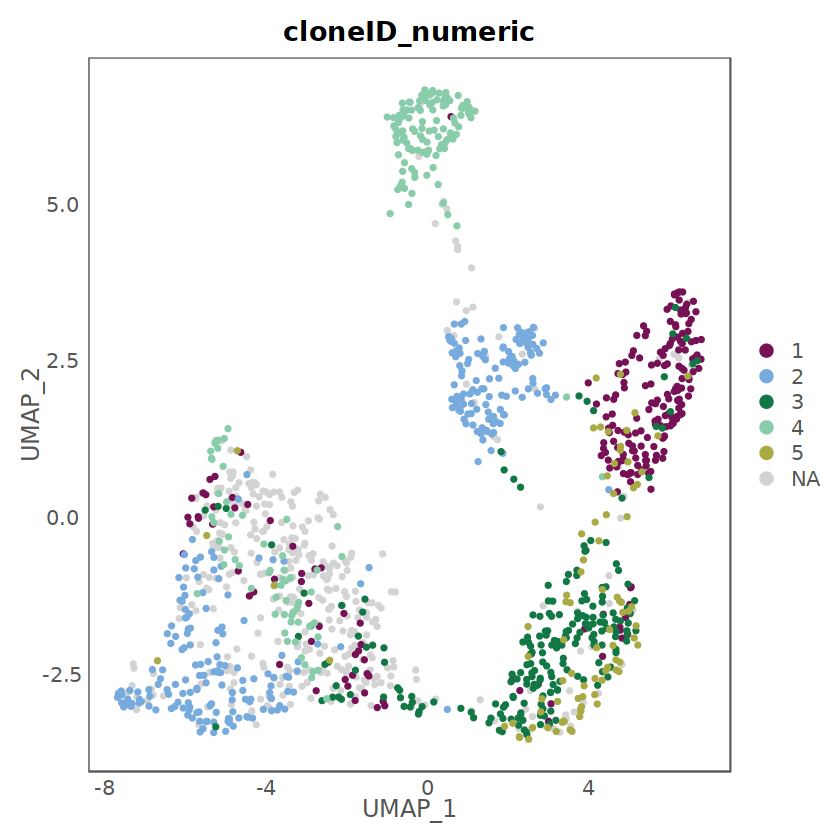

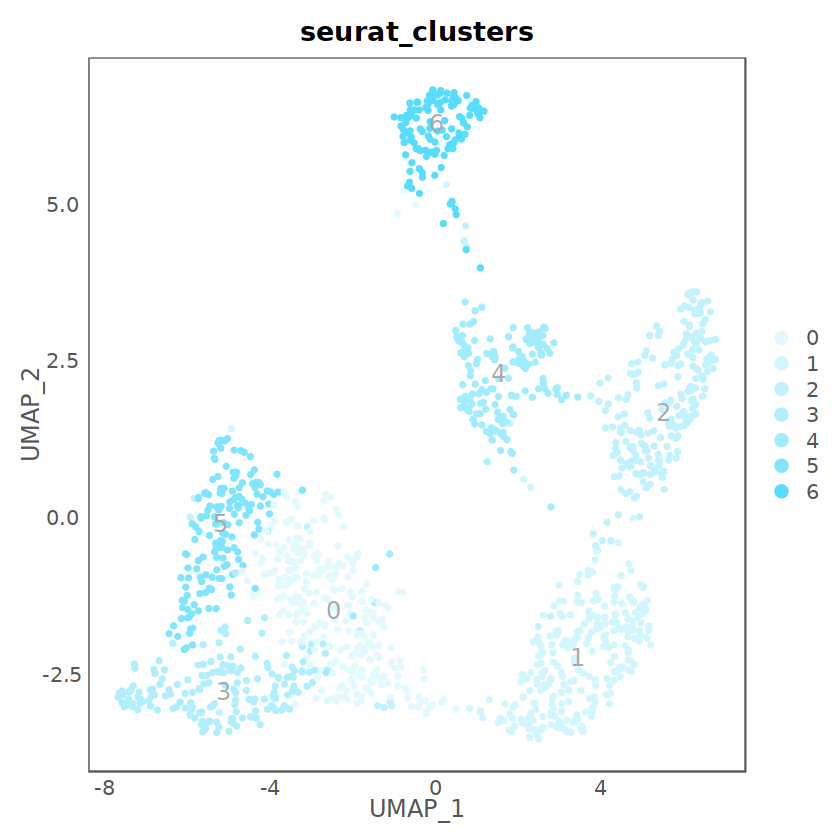

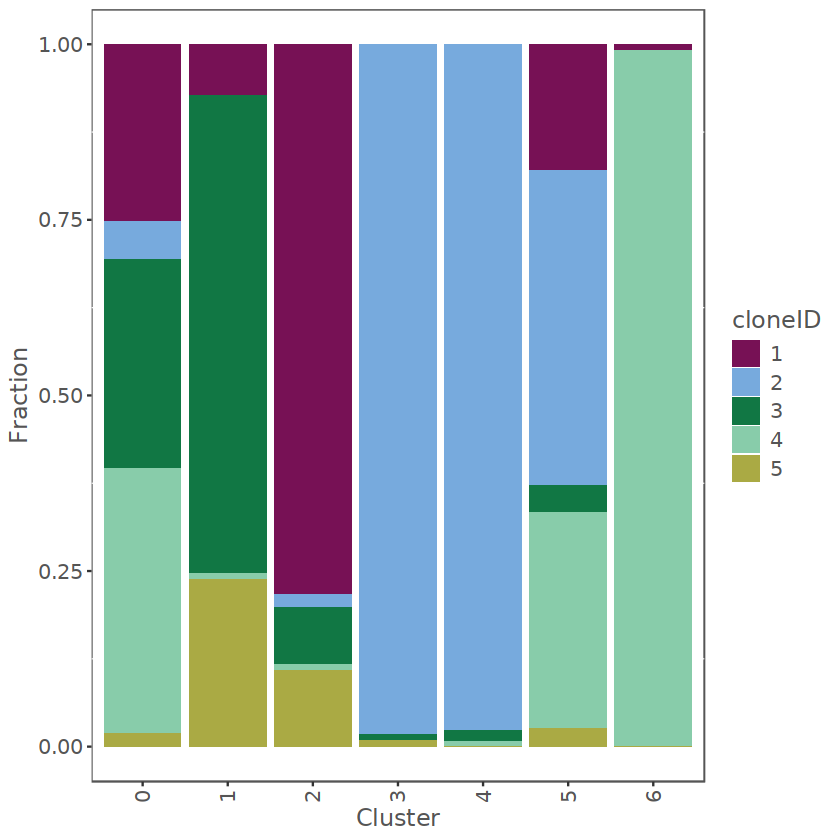

[1] "Plotting module expression boxplots"


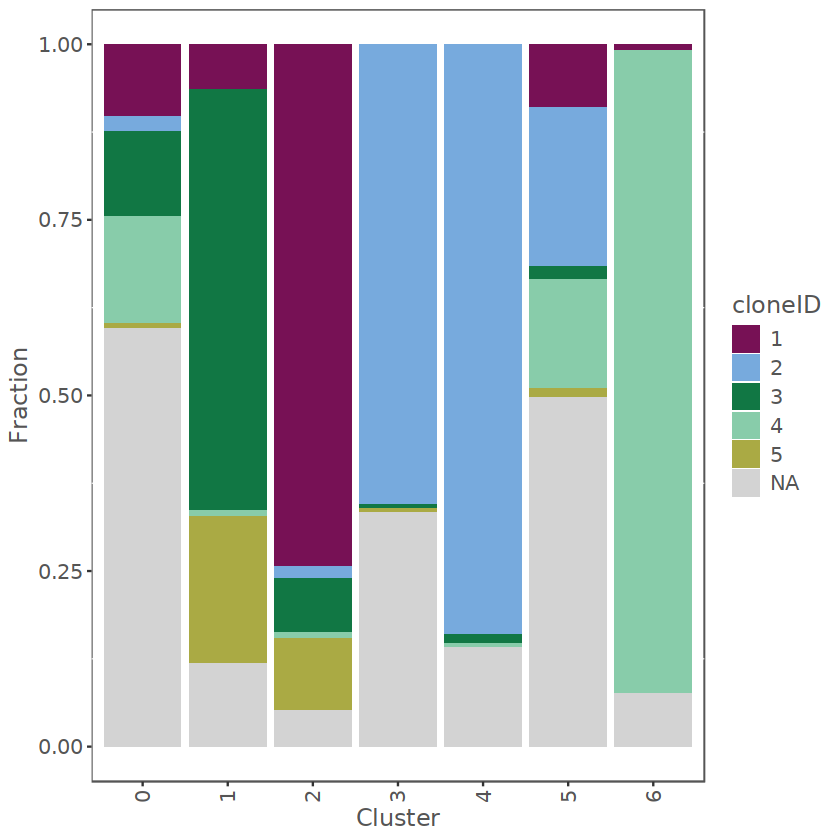

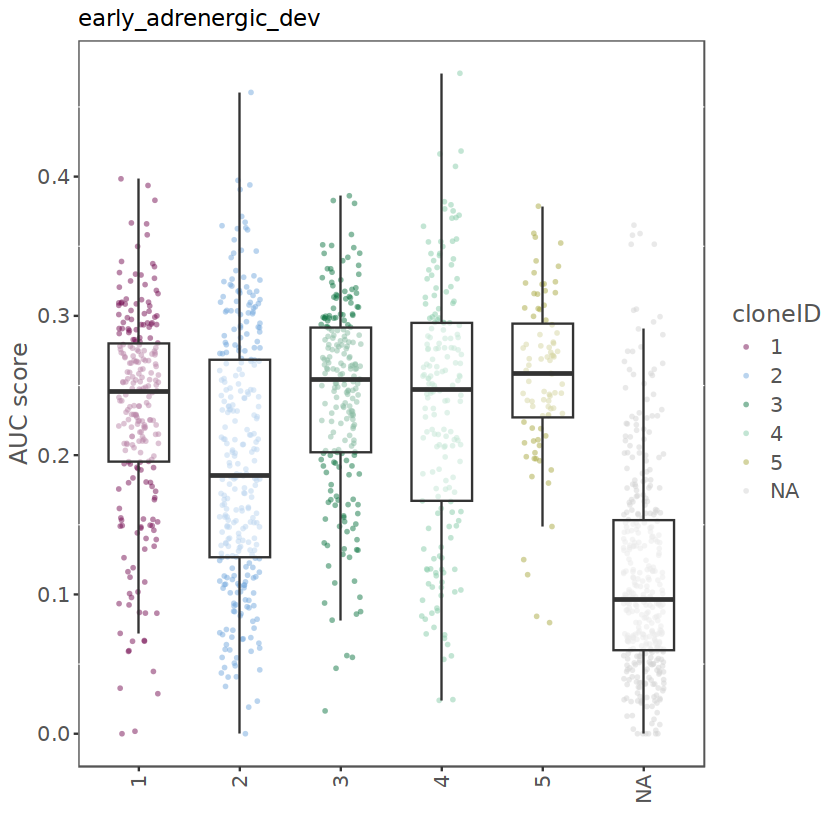

[1] "Working on dataset: multi_seq_17_1"
[1] "Number of cells: 1869"


Centering and scaling data matrix



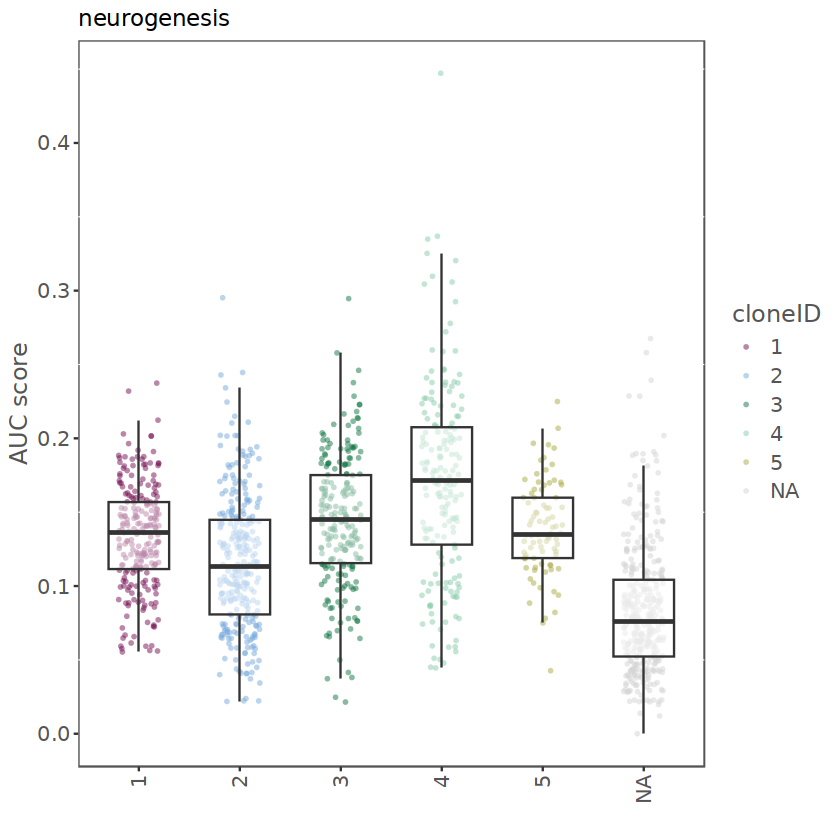

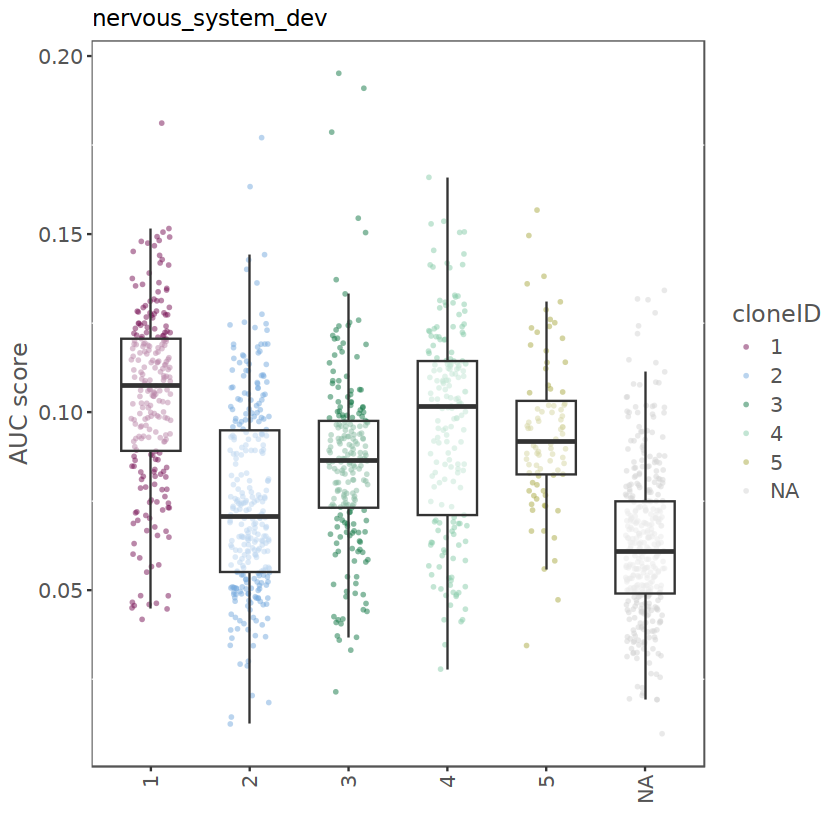

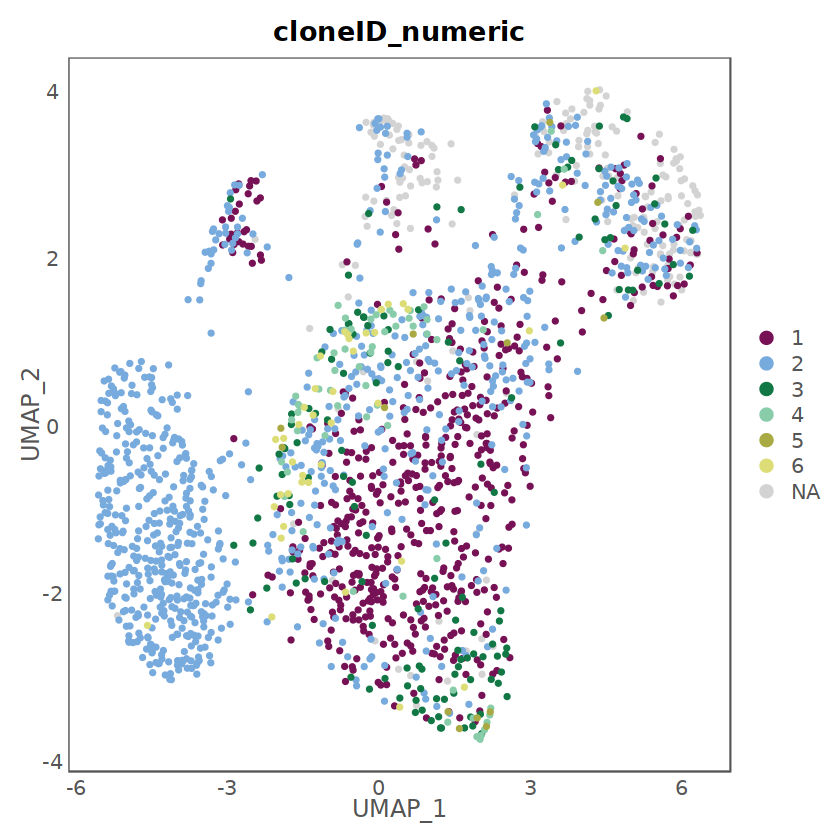

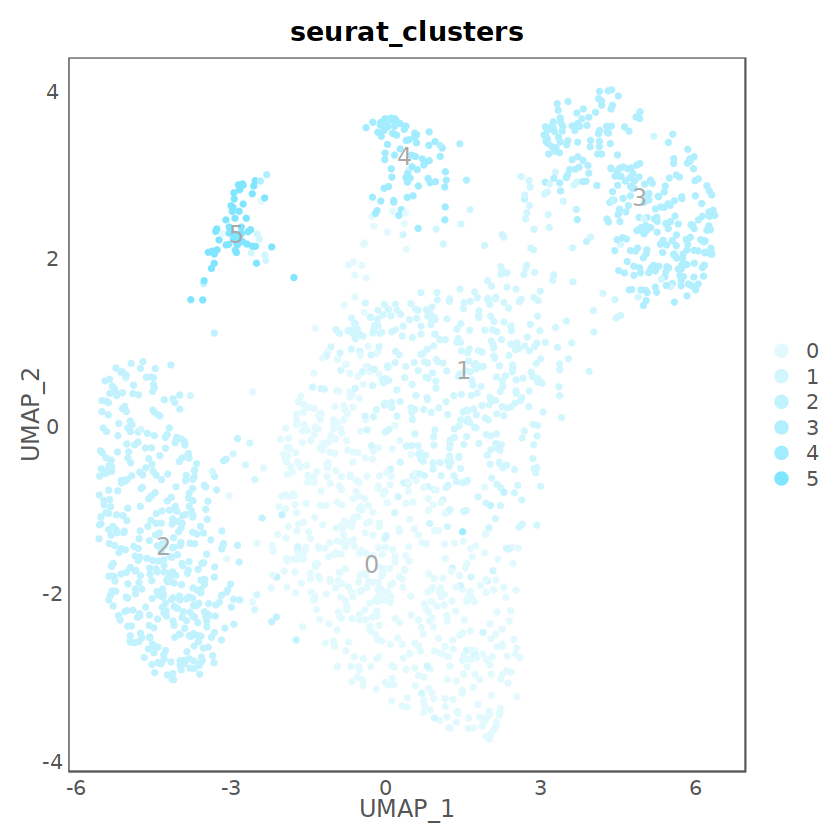

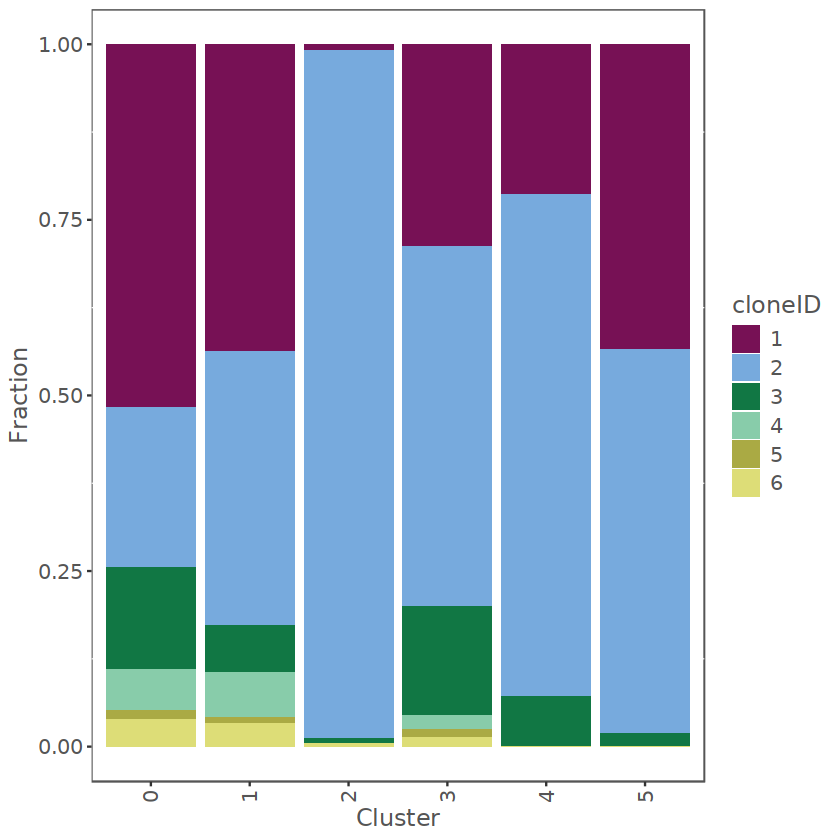

[1] "Plotting module expression boxplots"


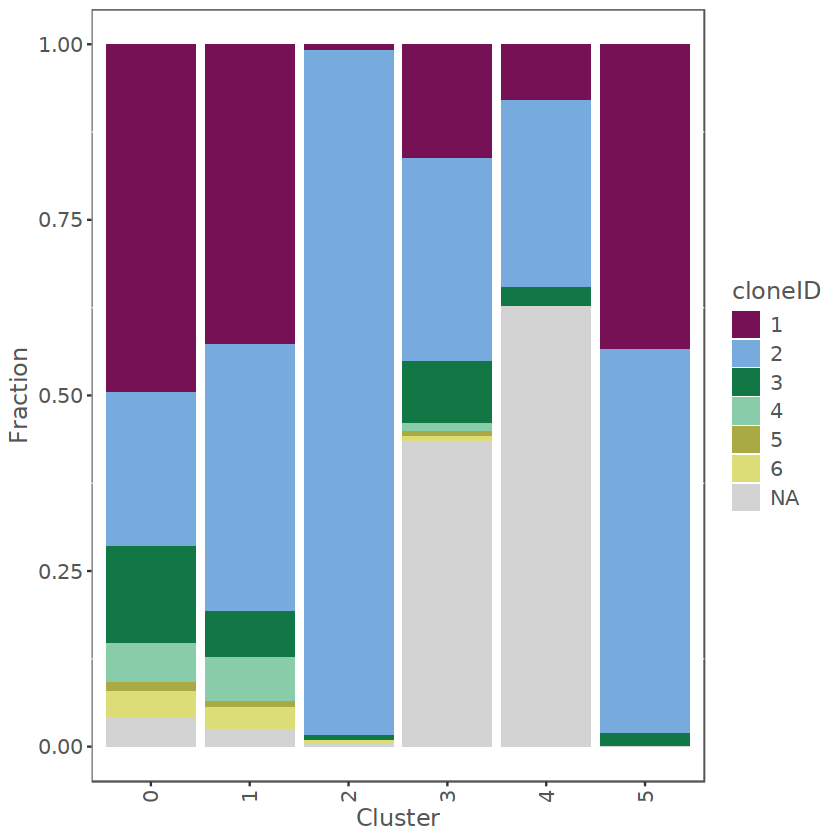

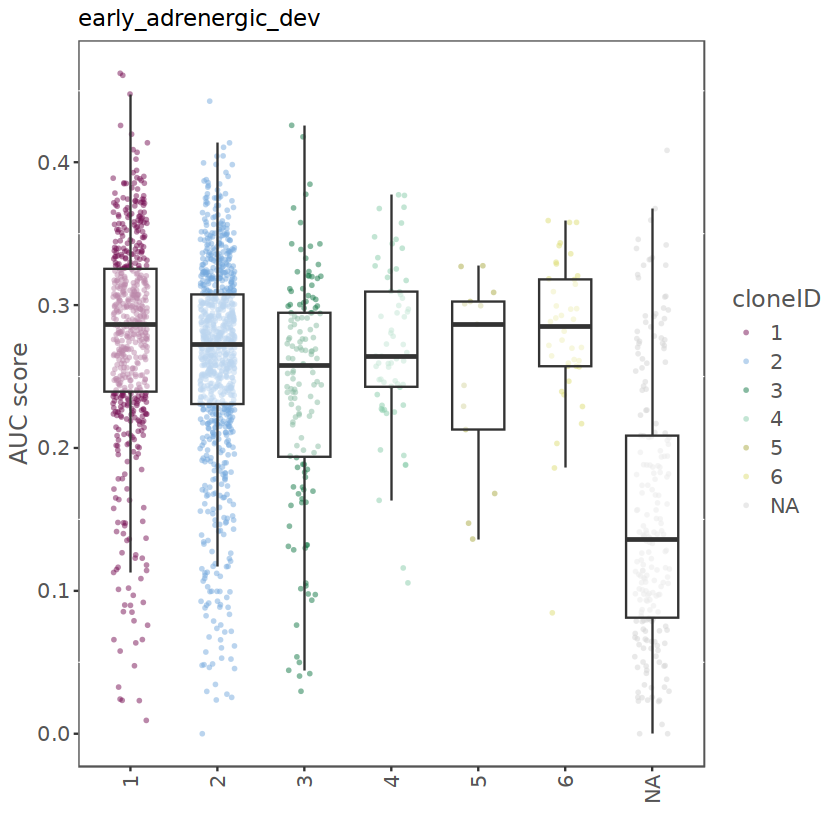

[1] "Working on dataset: multi_seq_17_3"
[1] "Number of cells: 801"


Centering and scaling data matrix



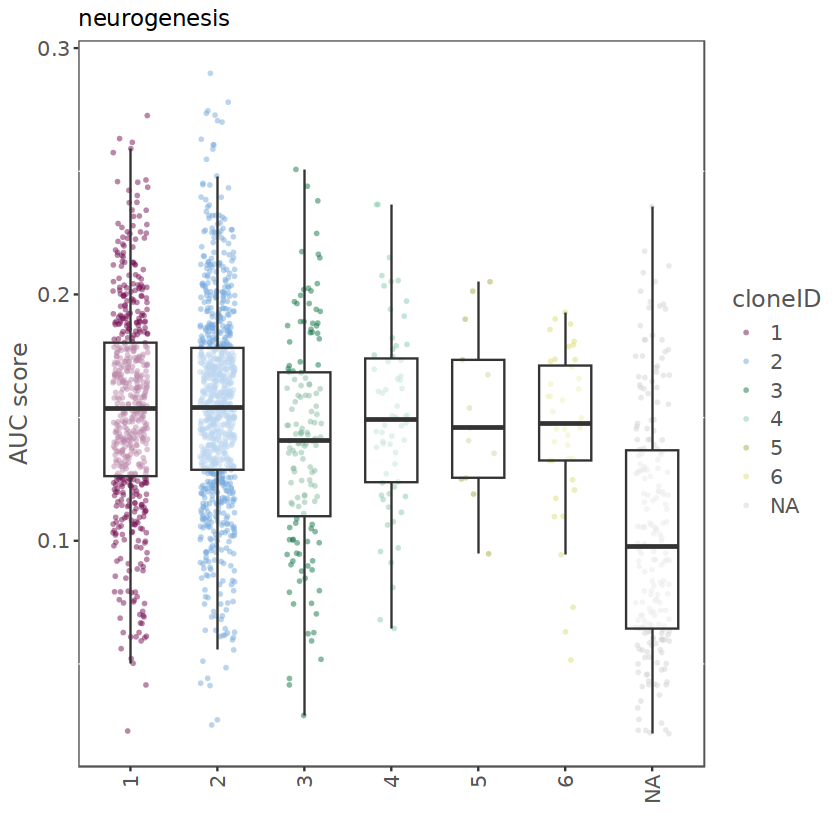

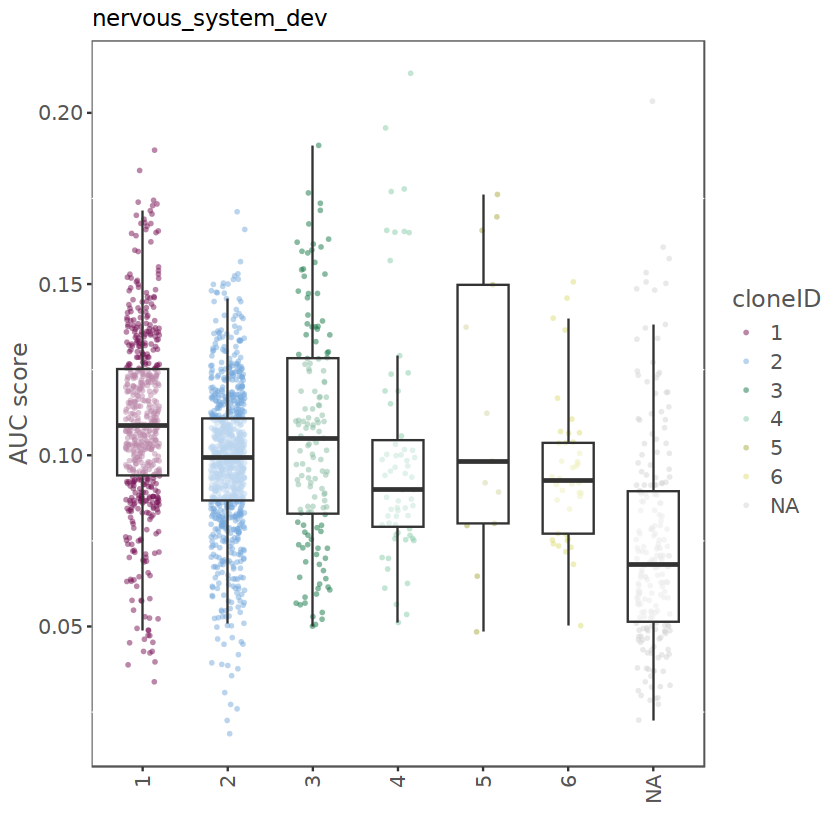

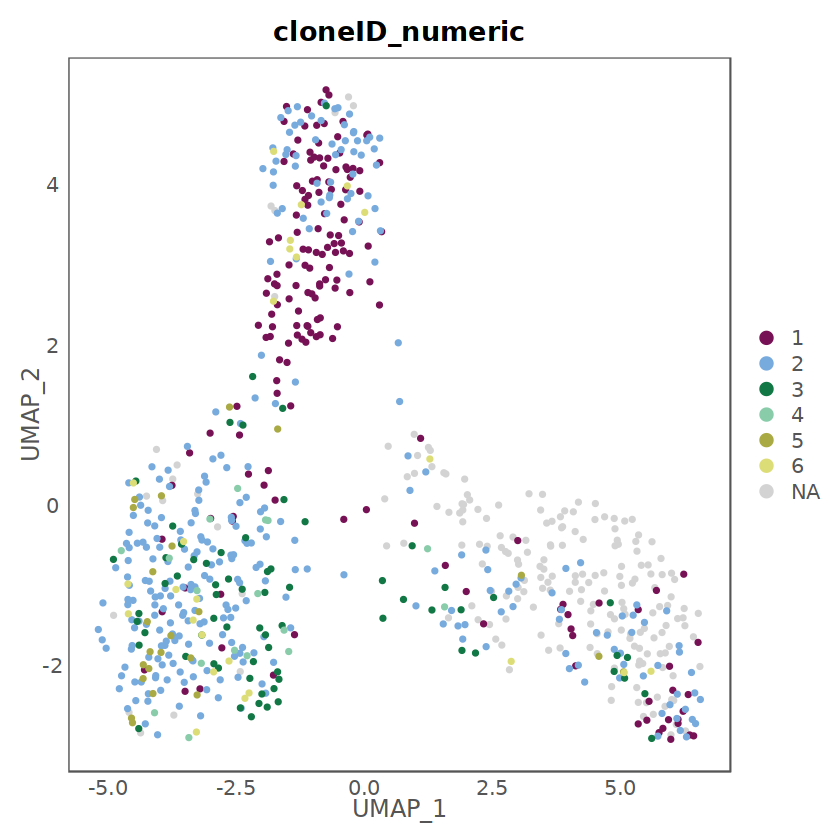

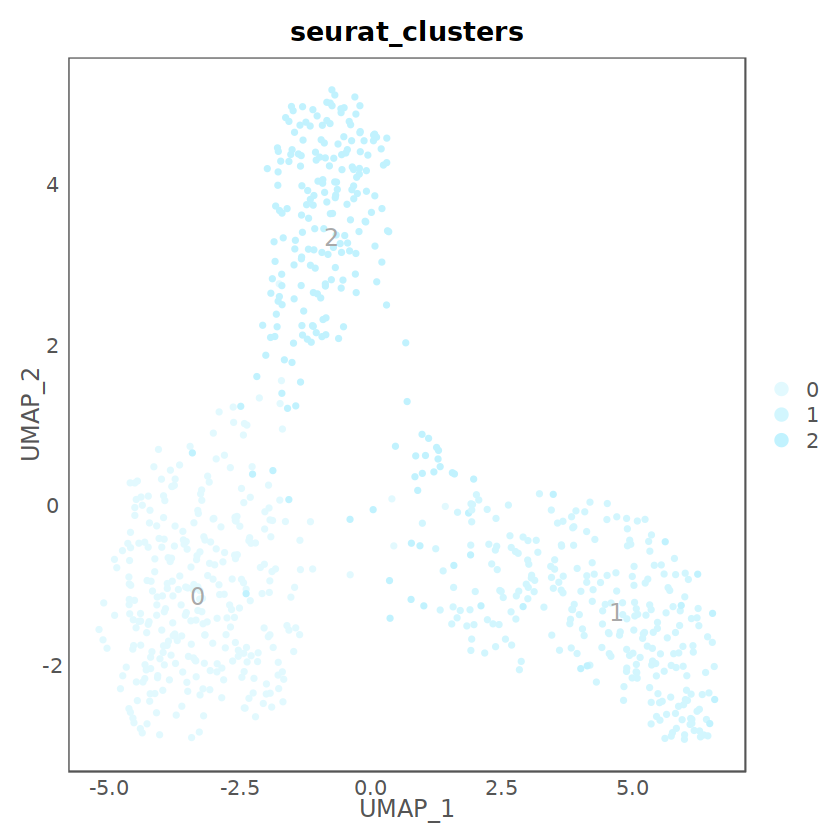

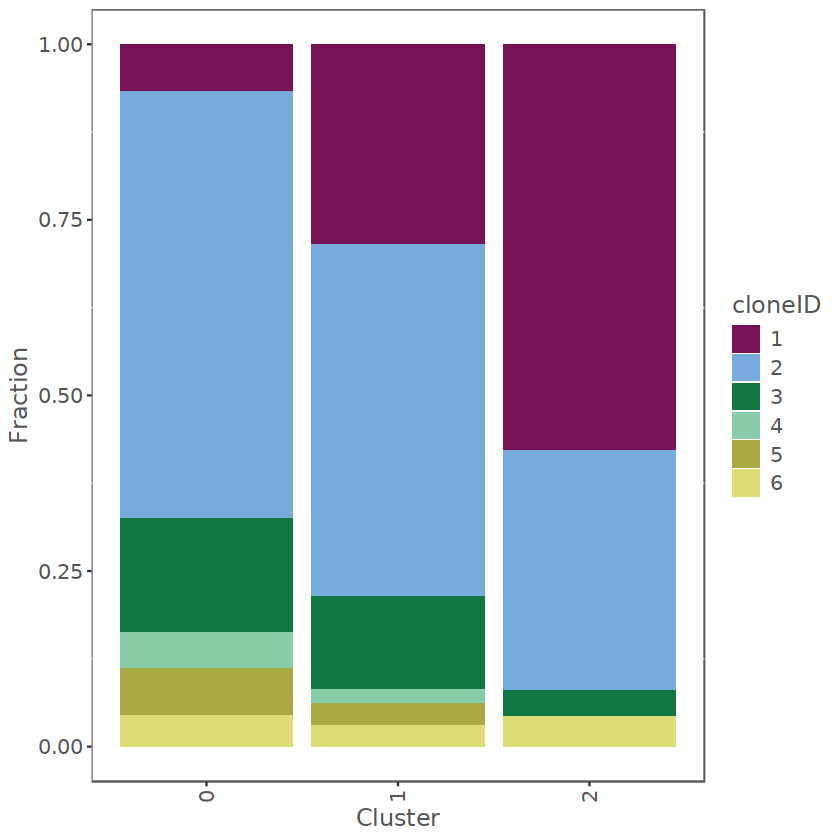

[1] "Plotting module expression boxplots"


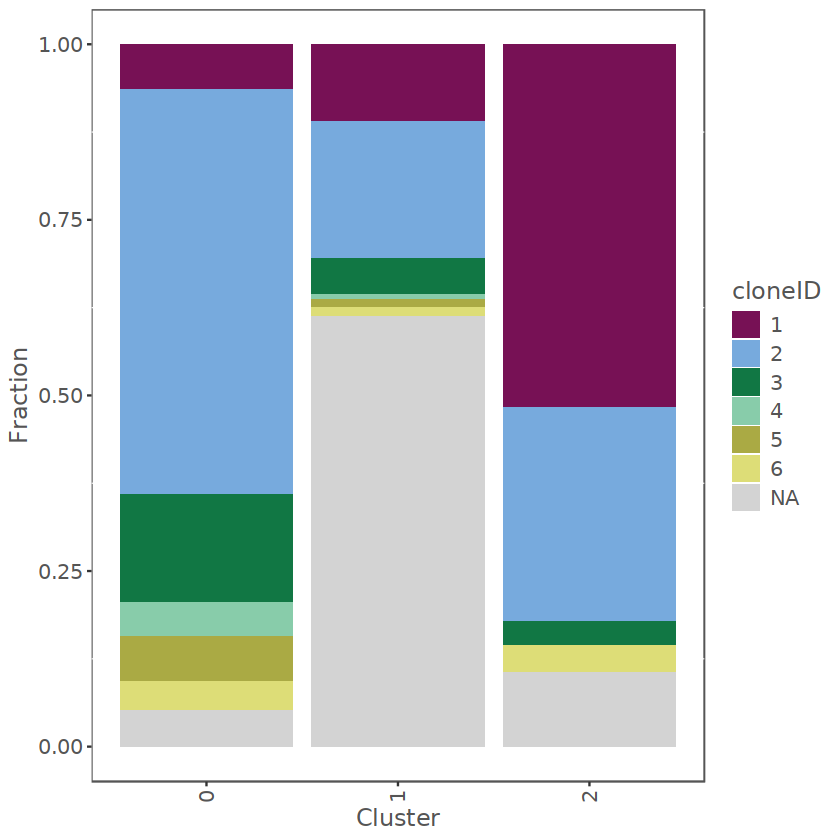

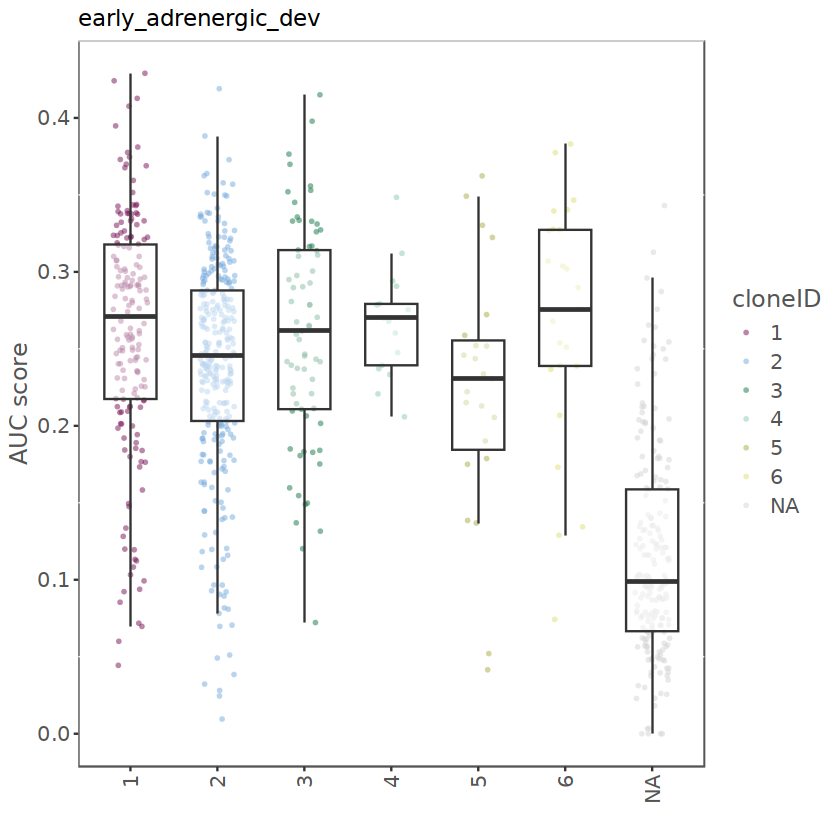

[1] "Working on dataset: multi_seq_17_2"
[1] "Number of cells: 1880"


Centering and scaling data matrix



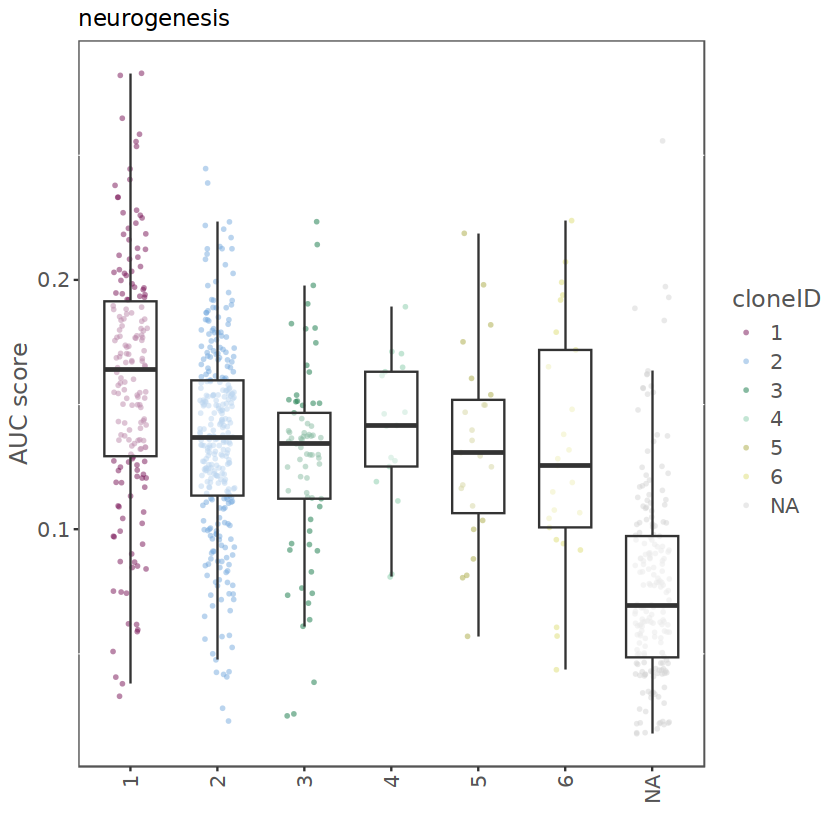

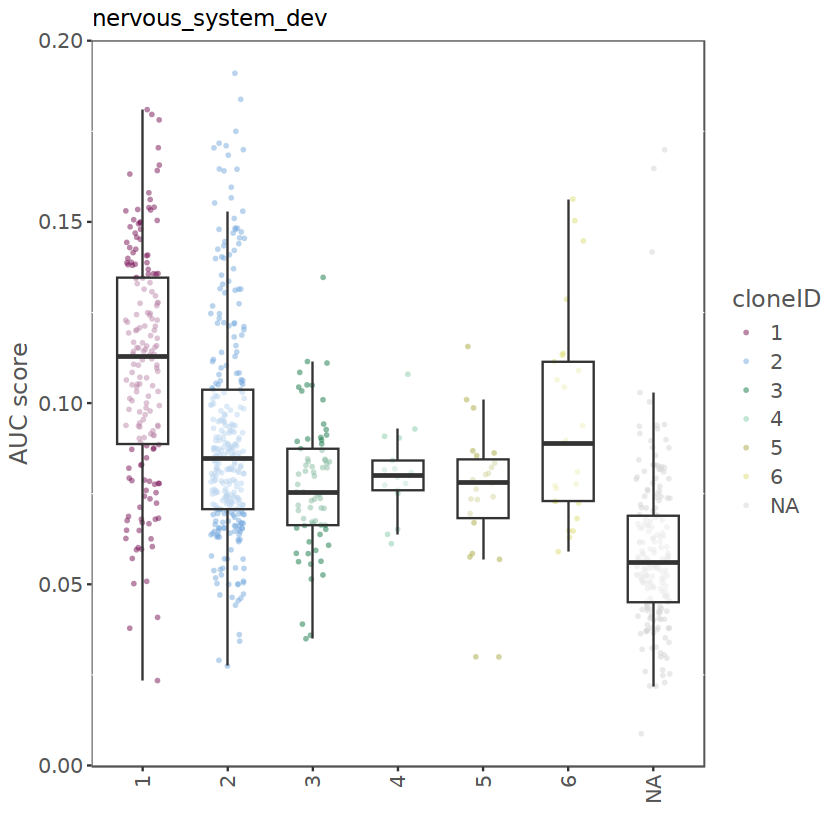

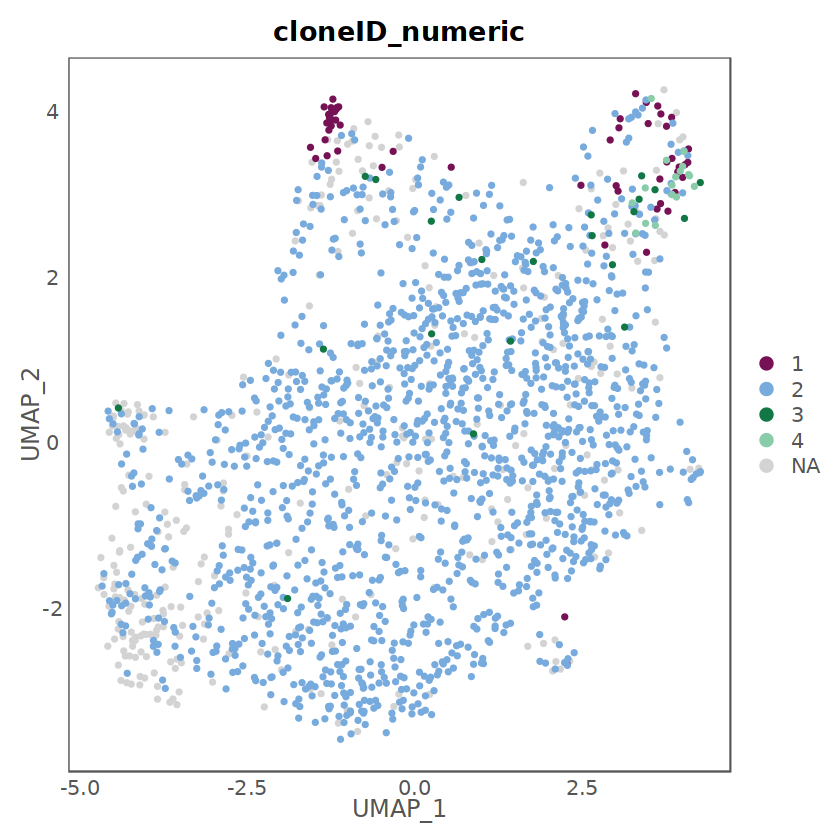

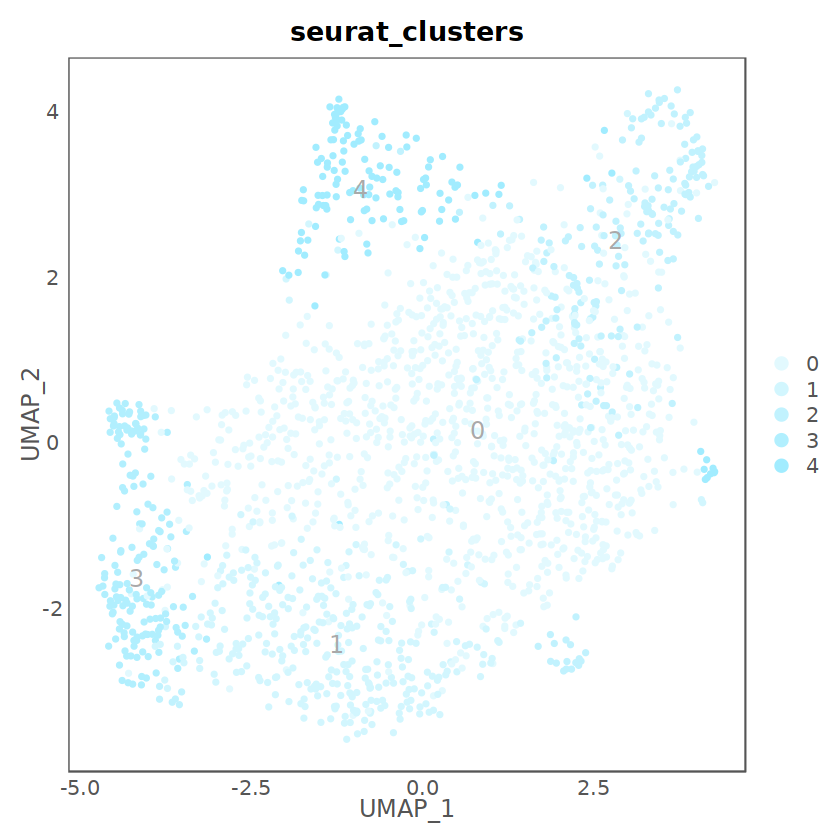

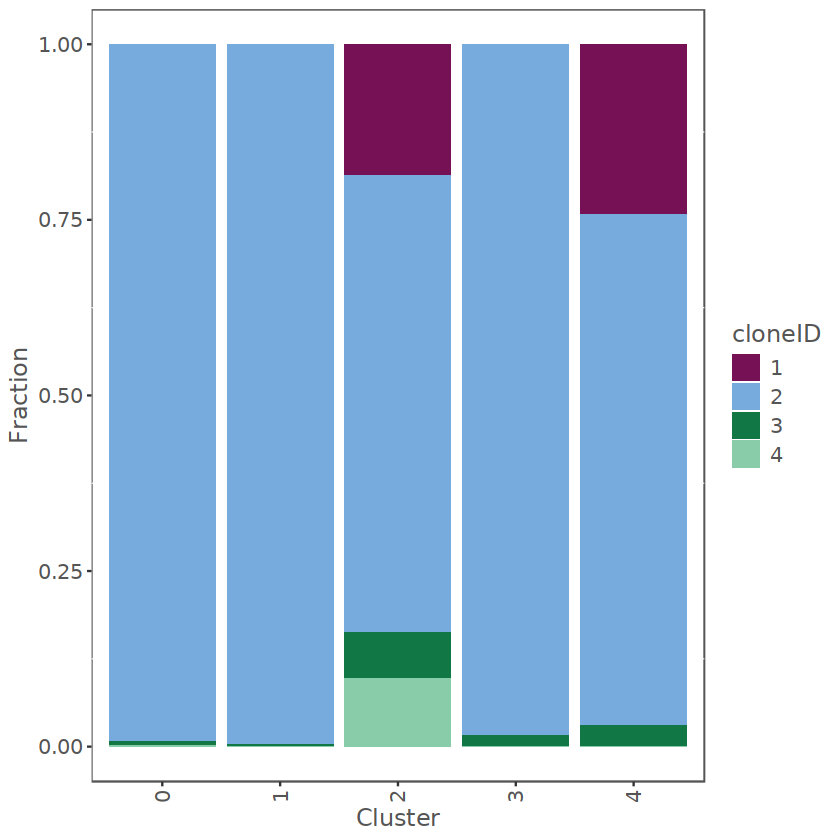

[1] "Plotting module expression boxplots"


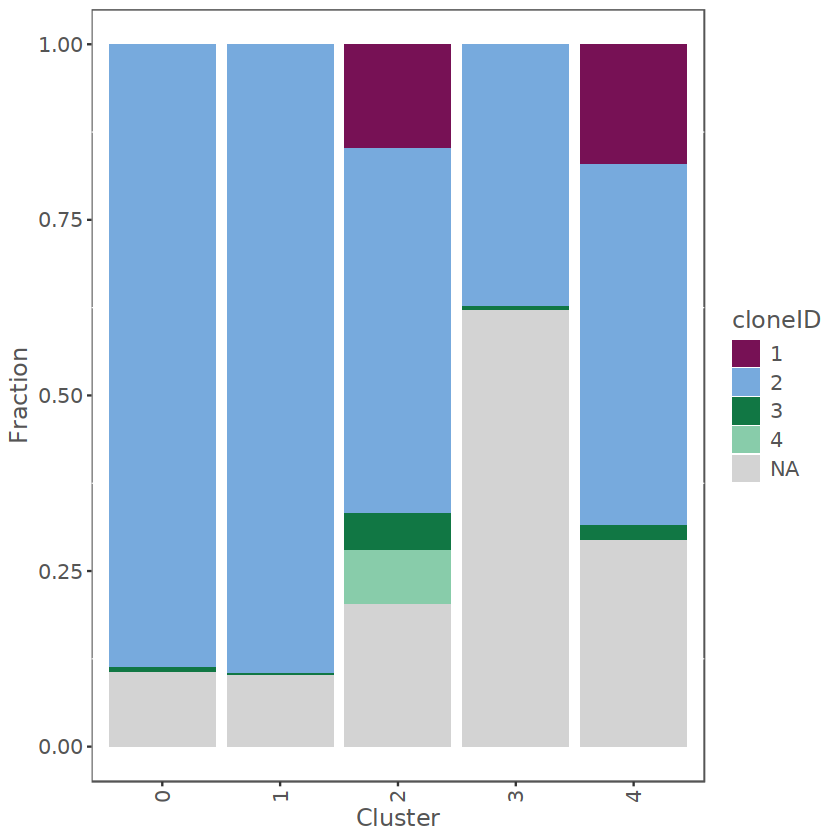

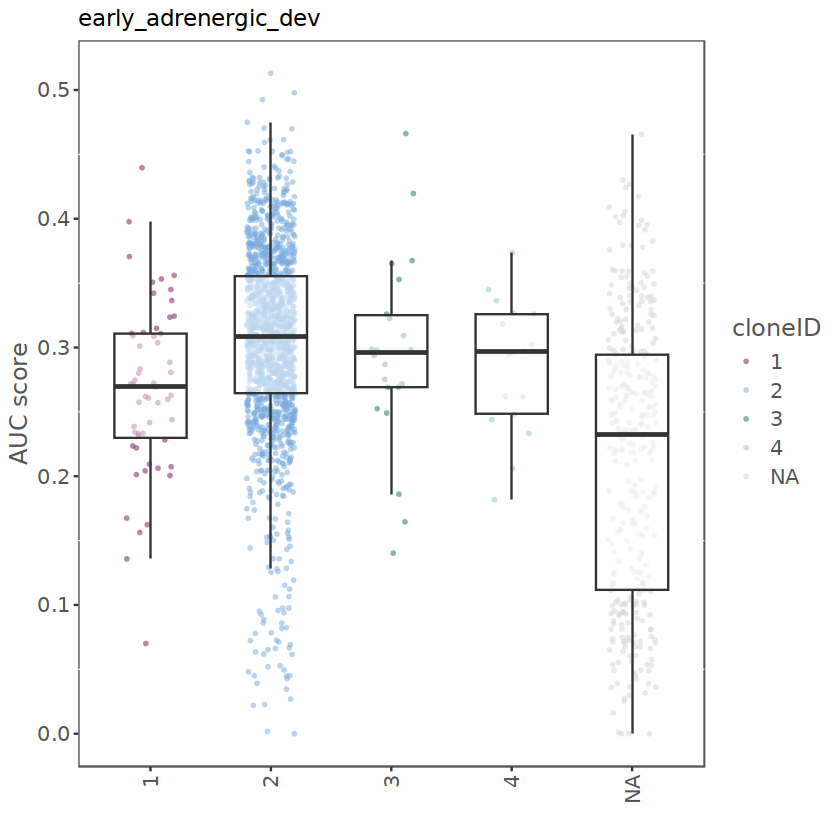

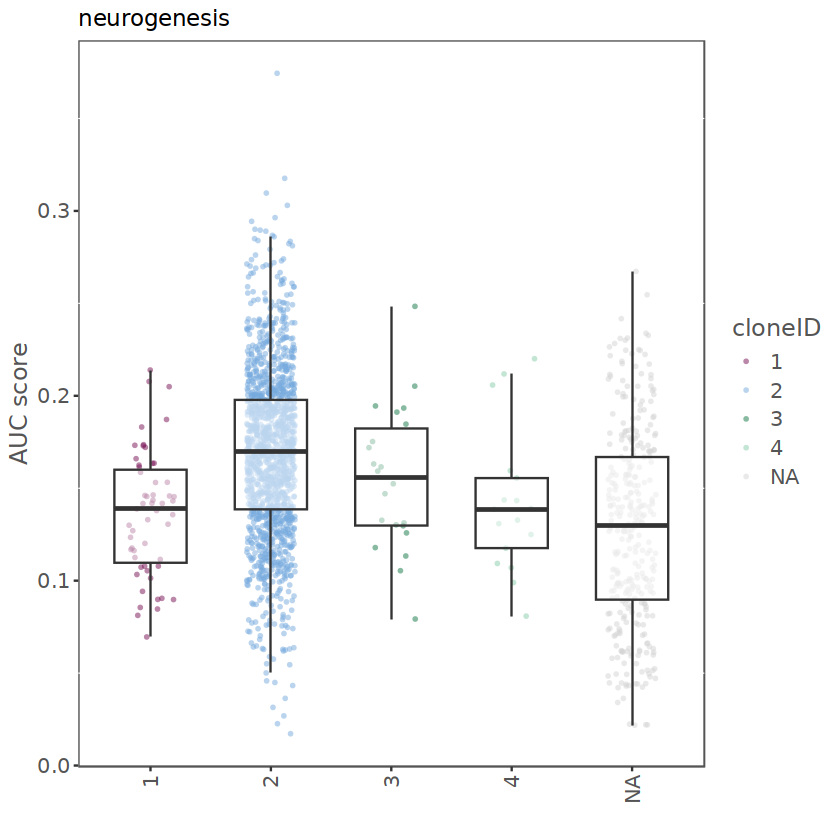

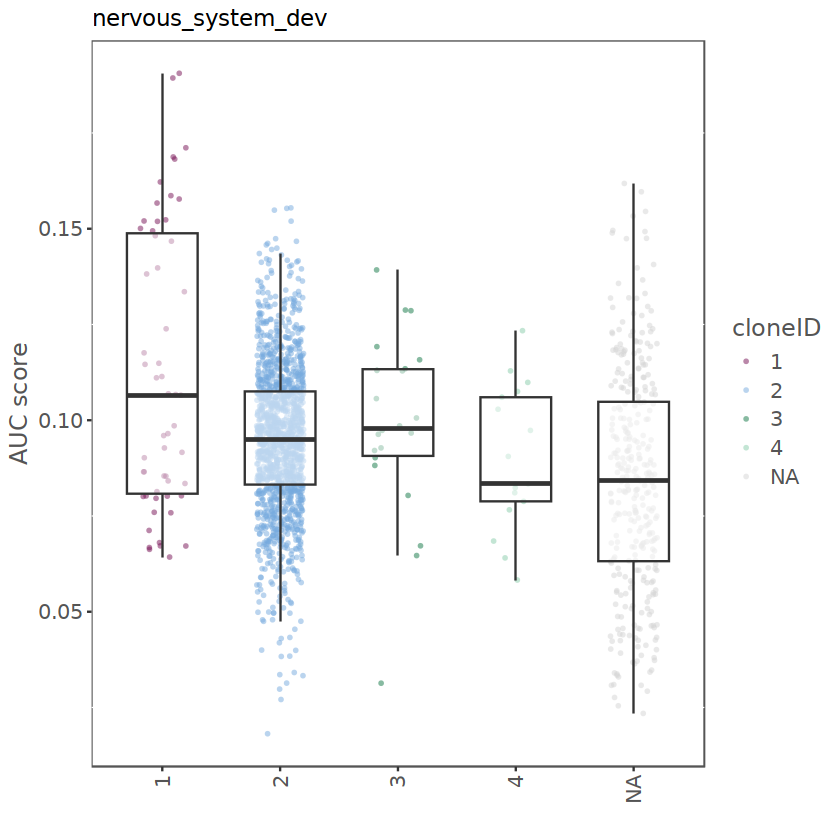

In [86]:
# Per sample_fish
samples_to_plot <- unique(dat@meta.data$sample_fish)

#for(i in rev(1:length(samples_to_plot))){
for(i in rev((length(samples_to_plot)-3):length(samples_to_plot))){

# Get the sub data set
    sample_name <- samples_to_plot[i]

    Idents(dat) <- 'sample_fish'

    sub <- subset(dat, idents = sample_name)
    
# Stop, if there is only one clone in the data or if the sample contains less than 25 cells    
    if(length(unique(sub$fish_clone)) == 1 || ncol(sub) < 25){
        next
    }

# Process the sub data set to get clusters and UMAP-coordinates
    print(paste0('Working on dataset: ',sample_name))
    print(paste0('Number of cells: ',ncol(sub)))

    all.genes <- rownames(x = sub)
    sub <- ScaleData(object = sub, features = all.genes)
    sub <- FindVariableFeatures(object = sub,selection.method = 'vst', nfeatures = 1500)

    # PCA
    if(ncol(sub) < 50){
        sub <- RunPCA(object = sub, features = VariableFeatures(object = sub), npcs = 20, verbose = F)
        ndims <- 15
    }else if(ncol(sub) < 120){
        sub <- RunPCA(object = sub, features = VariableFeatures(object = sub), npcs = 30, verbose = F)
        ndims <- 20
    }else{
        sub <- RunPCA(object = sub, features = VariableFeatures(object = sub), npcs = 60, verbose = F)
        ndims <- 25
    }

    # Clustering
    k <- round(max(20,sqrt(ncol(sub)))/4)
    if(k %% 2 == 0) {k <- k+1}
    if(k > 41) {k <- 41}

    sub <- FindNeighbors(object = sub, dims = 1:ndims, k.param = k, verbose = F)
    sub <- FindClusters(object = sub, resolution = 0.4, verbose = F)

    sub <- RunUMAP(sub, reduction = "pca", dims = 1:ndims, n.components = 2, verbose = F)

    
# Plot UMAPS

    print(
        DimPlot(object = sub, reduction = 'umap', pt.size = 1, group.by = "cloneID_numeric", dims = c(1,2), cols = tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)], order = T, na.value="light grey") +
                 NoAxes() +
                 mytheme_angledYtitle
         )
    
    ploto <- DimPlot(object = sub, reduction = 'umap', pt.size = 1, group.by = "cloneID_numeric", dims = c(1,2), cols = tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)], order = T, na.value="light grey") +
                 NoAxes() +
                 mytheme_angledYtitle

    #ggsave(plot = ploto, filename = paste0("pics/EntireTum_UMAP_tumour_sample_fish_",sample_name,"_ncells_",ncol(sub),"_fishCloneIDnumeric.png"), width = 4.1, height = 3.4, dpi = 900)
    rm(ploto)


    ploto <- DimPlot(object = sub, reduction = 'umap', pt.size = 1, group.by = "cloneID", dims = c(1,2), cols = tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)], order = T, na.value="light grey") +
                 NoAxes() +
                 mytheme_angledYtitle
    
    #ggsave(plot = ploto, filename = paste0("pics/EntireTum_UMAP_tumour_sample_fish_",sample_name,"_ncells_",ncol(sub),"_fishCloneID.png"), width = 4.6, height = 3.8, dpi = 500)
    rm(ploto)


    ploto <- DimPlot(object = sub, reduction = 'umap', pt.size = 1, group.by = "tumor_id", dims = c(1,2), cols = tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)], shuffle = T, na.value="light grey") +
                 NoAxes() +
                 mytheme_angledYtitle
    
    #ggsave(plot = ploto, filename = paste0("pics/EntireTum_UMAP_tumour_sample_fish_",sample_name,"_ncells_",ncol(sub),"_tumor.png"), width = 4.2, height = 3.4, dpi = 900)
    rm(ploto)

    ploto <- DimPlot(object = sub, reduction = 'umap', pt.size = 1, group.by = "location", dims = c(1,2), cols = tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)], shuffle = T, na.value="light grey") +
                 NoAxes() +
                 mytheme_angledYtitle
    
    #ggsave(plot = ploto, filename = paste0("pics/EntireTum_UMAP_tumour_sample_fish_",sample_name,"_ncells_",ncol(sub),"_location.png"), width = 7.6, height = 6.5, dpi = 500)
    rm(ploto)
    
    print(
        DimPlot(object = sub, reduction = 'umap', pt.size = 1, group.by = "seurat_clusters", dims = c(1,2), cols = blues_24[2:length(blues_24)],
                label = T, shuffle = T, na.value="light grey", label.color = "dark grey", label.size = 5) +
                NoAxes() +
                mytheme_angledYtitle
    )
    
    ploto <- DimPlot(object = sub, reduction = 'umap', pt.size = 1, group.by = "seurat_clusters", dims = c(1,2), cols = blues_24[2:length(blues_24)],
                     label = T, shuffle = T, na.value="light grey", label.color = "dark grey", label.size = 5) +
                     NoAxes() +
                     mytheme_angledYtitle
    
    #ggsave(plot = ploto, filename = paste0("pics/EntireTum_UMAP_tumour_sample_fish_",sample_name,"_ncells_",ncol(sub),"_seuratClusters.png"), width = 4.05, height = 3.4, dpi = 900)
    rm(ploto)


# Plot the fraction of cells from a clone belonging to each cluster       
      comp_table <- as.data.frame(table(sub$cloneID_numeric, sub$seurat_clusters))
        colnames(comp_table) <- c("cloneID", "Cluster", "Fraction")
    
        #pdf(paste0("pics/Fraction_clone_per_cluster_",sample_name,".pdf"), width = 6, height = 2.4)
            print(
               ggplot(comp_table, aes(fill=cloneID, y=Fraction, x=Cluster)) + 
                    geom_bar(position="fill", stat="identity") +
                    scale_fill_manual(values=tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)]) +
                    mytheme_angledX
                )
        #dev.off()


# Plot the fraction of cells from a location belonging to each clone while including cells not assigned to a clone
      sub@meta.data$cloneID_numeric[is.na(sub@meta.data$cloneID_numeric)] <- 'NA'
    
      comp_table <- as.data.frame(table(sub$cloneID_numeric, sub$seurat_clusters))
        colnames(comp_table) <- c("cloneID", "Cluster", "Fraction")

        #pdf(paste0("pics/Fraction_clone_per_cluster_",sample_name,"_withNAs.pdf"), width = 6, height = 2.4)
            print(
               ggplot(comp_table, aes(fill=cloneID, y=Fraction, x=Cluster)) + 
                    geom_bar(position="fill", stat="identity") +
                    scale_fill_manual(values=c(tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)][1:length(unique(comp_table$cloneID))-1],'light grey')) +
                    mytheme_angledX
                )
        #dev.off()

# Plot gene module expression score boxplots for clones
    print('Plotting module expression boxplots')

    sub@meta.data$cloneID_numeric <- as.factor(sub@meta.data$cloneID_numeric)
    
    # Iterate through all modules of interest
    #for(j in 1:length(set_all)){
    for(j in 1:3){
        
       # Perform pairwise Wilcoxon rank sum test for significance of module expression difference between clones
        if(length(unique(sub@meta.data$cloneID_numeric)) > 2){

            significant_pairs <- pairwise_wilcox_for_plot(set_name = set_all[j], group_name = 'cloneID_numeric', dataframe = sub@meta.data)
            significant_pairs$group1 <- factor(significant_pairs$group1, levels = levels(sub@meta.data$cloneID_numeric))
            significant_pairs$group2 <- factor(significant_pairs$group2, levels = levels(sub@meta.data$cloneID_numeric))
            sig_entry_number <- nrow(significant_pairs[significant_pairs$group1 != 'NA' & significant_pairs$group2 != 'NA' & significant_pairs$label != 'ns',])
            significant_pairs <- significant_pairs[order(significant_pairs$y_position),]
            y_positions <- significant_pairs$y_position[1:sig_entry_number]

            significant_pairs <- significant_pairs[significant_pairs$group1 != 'NA' & significant_pairs$group2 != 'NA',]
            significant_pairs <- significant_pairs[significant_pairs$label != 'ns',]
            significant_pairs$y_position <- y_positions

        }else{

            significant_pairs <- data.frame()

        }

        if(nrow(significant_pairs) != 0){

                ploto <- ggplot(sub@meta.data, aes(x = cloneID_numeric, y = sub@meta.data[,set_all[j]]), verbose = F) +
                    geom_jitter(size = 0.8, width = 0.2, height = 0, aes(col = cloneID_numeric, fill = cloneID_numeric), shape=16, alpha = 0.5) +
                    geom_boxplot(width = 0.6, outlier.shape = NA, alpha = 0.5) +
                    geom_segment(data = significant_pairs, 
                               aes(x = as.numeric(group1), xend = as.numeric(group2),
                                   y = y_position, yend = y_position), 
                               inherit.aes = FALSE, color = "dark grey") +
                   geom_segment(data = significant_pairs,
                                   aes(x = as.numeric(group1), xend = as.numeric(group1),
                                       y = y_position, yend = y_position - 0.01),  # Adjust height as needed
                                   inherit.aes = FALSE, color = "dark grey") +
                    geom_segment(data = significant_pairs,
                                   aes(x = as.numeric(group2), xend = as.numeric(group2),
                                       y = y_position, yend = y_position - 0.01),  # Adjust height as needed
                                   inherit.aes = FALSE, color = "dark grey") +
                    geom_text(data = significant_pairs,
                                aes(x = (as.numeric(group1) + as.numeric(group2)) / 2, 
                                    y = y_position + 0.02, label = label),
                                inherit.aes = FALSE, size = 4, color = "dark grey") +
                    scale_color_manual(values=c(tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)][1:length(unique(sub@meta.data$cloneID_numeric))-1],'light grey')) +
                    scale_fill_manual(values=alpha(c(tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)][1:length(unique(sub@meta.data$cloneID_numeric))-1],'light grey'),0.3), guide = 'none') +
                    labs(col = 'cloneID', title = module_metnames[j], y = 'AUC score', x = '') +
                    mytheme_angledX

                #ggsave(plot = ploto, filename = paste0("pics/ScoreBox_perClone_sample_fish_",sample_name,"_module_",module_metnames[j],"_withStats.png"), width = 5.3, height = (4+(nrow(significant_pairs)/2)), dpi = 500)
                rm(ploto)        

            
            #pdf(paste0("pics/ScoreBox_perClone_sample_fish_",sample_name,"_module_",module_metnames[j],".pdf"), width = 3.6, height = 2.4)
                print(
                   ggplot(sub@meta.data, aes(x = cloneID_numeric, y = sub@meta.data[,set_all[j]]), verbose = F) +
                        geom_jitter(size = 1, width = 0.2, height = 0, aes(col = cloneID_numeric, fill = cloneID_numeric), shape=16, alpha = 0.5) +
                        geom_boxplot(width = 0.6, outlier.shape = NA, alpha = 0.5) +
                        scale_color_manual(values=c(tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)][1:length(unique(sub@meta.data$cloneID_numeric))-1],'light grey')) +
                        scale_fill_manual(values=alpha(c(tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)][1:length(unique(sub@meta.data$cloneID_numeric))-1],'light grey'),0.3), guide = 'none') +
                        labs(col = 'cloneID', title = module_metnames[j], y = 'AUC score', x = '') +
                        mytheme_angledX
                    )
            #dev.off()

        }else{
            
            #pdf(paste0("pics/ScoreBox_perClone_sample_fish_",sample_name,"_module_",module_metnames[j],".pdf"), width = 3.6, height = 2.4)
            print(
               ggplot(sub@meta.data, aes(x = cloneID_numeric, y = sub@meta.data[,set_all[j]]), verbose = F) +
                    geom_jitter(size = 1, width = 0.2, height = 0, aes(col = cloneID_numeric, fill = cloneID_numeric), shape=16, alpha = 0.5) +
                    geom_boxplot(width = 0.6, outlier.shape = NA, alpha = 0.5) +
                    scale_color_manual(values=c(tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)][1:length(unique(sub@meta.data$cloneID_numeric))-1],'light grey')) +
                    scale_fill_manual(values=alpha(c(tol21rainbow[c(1,6,10,12,14,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,3,4,9,12,2)][1:length(unique(sub@meta.data$cloneID_numeric))-1],'light grey'),0.3), guide = 'none') +
                    labs(col = 'cloneID', title = module_metnames[j], y = 'AUC score', x = '') +
                    mytheme_angledX
                )
            #dev.off()
            
        }
    }

}

## Calculate differential module expression

### Reload and prepare data

In [266]:
# Load Seurat metadata with high-resolution clone assignments and module scores
dat <- readRDS(paste0('data/seur_obj_NBcells_with_clones_and_scores_DR_NB_modules_',dat_name,'.rds'))

# Remove cells that have not been assigned to a clone
cells_keep <- rownames(dat@meta.data[!is.na(dat@meta.data$fish_clone),])
dim(dat)
dat <- subset(dat, cells = cells_keep)
dim(dat)


[1] 26275 62886

[1] 26275 23824

In [274]:
# Load final module table
modules_pan <- read.delim('/gene_modules/final_gene_modules_list.csv', sep = ',', stringsAsFactors = F, header = T)

# Re-format into list
modules_pan <- as.list(modules_pan)

# Double-check that common gene names contain correct set of special characters
modules_pan <- lapply(modules_pan, function(x) gsub("si\\.","si:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("zgc\\.","zgc:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("mt\\.","mt-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("dkey\\.","dkey-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("h211\\.","h211-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("ch73\\.","ch73-",x))

# Remove empty entries
modules_pan <- lapply(modules_pan, function(x) {
  # Remove NA and empty string "" entries
  x[!(is.na(x) | x == "")]
})

# Remove modules that are too short
modules_pan <- modules_pan[lengths(modules_pan) > 5]

In [275]:
# Get order of modules in data
mod_order <- read.delim('data/mod_name_order_in_data.csv', sep = ',', stringsAsFactors = F, header = T, row.names = 1)

mod_order <- mod_order$x

In [276]:
# Get overall stats for expression of the modules

# Get module names and extract data
b1 <- 1
b2 <- length(mod_order)

type <- 'auc'
module_names <- c(b1:b2)
module_metnames <- paste0(type,'_', mod_order)

# Reshape to long format
long_data <- dat@meta.data[,module_metnames] %>%
  pivot_longer(cols = starts_with(paste0(type)), 
               names_to = "module", 
               values_to = "expression")

# Calculate mean and standard deviation and write to file
module_stats <- aggregate(expression ~ module, data = long_data, function(x) c(mean = mean(x), sd = sd(x)))
module_stats <- do.call(data.frame, module_stats)

rm(long_data)
                          
write.csv(module_stats, paste0('expression_stats_alDRmods_',type,'_scores.csv'), quote = F)


In [277]:
# Add a few more info columns to metadata in preparation

# Unambiguous tumor identifier
dat@meta.data$sample_tumour <- paste0(dat@meta.data$dataset,'_',dat@meta.data$fish_id, '_', dat@meta.data$tumor_id)

# Unambiguous fish identifier
dat@meta.data$sample_fish <- paste0(dat@meta.data$dataset,'_',dat@meta.data$fish_id)

# Unambiguous tumor identifier with location info
dat@meta.data$sample_tumour_loc <- paste0(dat@meta.data$sample_tumour ,'_',dat@meta.data$location)

# Unambiguous sub-tumor and clone identifier
dat@meta.data$location_clones <- 'none'
dat@meta.data$location_clones <- paste0(dat@meta.data$fish_clone,'_tum_',dat@meta.data$tumor_id)

# Unambiguous fish and clone identifier
dat@meta.data$fish_loc_clone <- paste0(dat@meta.data$fish_clone ,'_loc_',dat@meta.data$location)


In [278]:
# Remove small clones from the data
freqs <- as.data.frame(table(dat@meta.data$location_clones))
freqs <- freqs$Var1[freqs$Freq >= 10]

Idents(dat) <- 'location_clones'

dat <- subset(dat, idents = freqs)

### Run diff expression test

**Get a list of all possible pairwise clone combinations to loop through.**

In [272]:
# Define the list of clones
clone_list <- unique(dat$location_clones)

In [273]:
# Generate all possible combinations of two elements
combinations <- combn(clone_list, 2, simplify = FALSE)

# Filter and exclude unwanted combinations
filtered_combinations <- lapply(combinations, function(x) {
  # Sort the elements in the combination
  sorted_combination <- sort(x)
  
  # Only keep the combination if it's not the same element and not a duplicated combination
  if (length(unique(x)) == 2 && !any(duplicated(sorted_combination))) {
    return(x)
  }
})

# Remove NULL entries (combinations to be excluded)
filtered_combinations <- Filter(Negate(is.null), filtered_combinations)

# Convert the result into a dataframe
combinations_df <- as.data.frame(t(do.call(cbind, filtered_combinations)))
colnames(combinations_df) <- c("Element1", "Element2")

rownames(combinations_df) <- paste0('it_',rownames(combinations_df))

In [130]:
head(combinations_df)


Element1                             
it_1 multi_seq_02_fish_3_clone_3_1_tum_3_1
it_2 multi_seq_02_fish_3_clone_3_1_tum_3_1
it_3 multi_seq_02_fish_3_clone_3_1_tum_3_1
it_4 multi_seq_02_fish_3_clone_3_1_tum_3_1
it_5 multi_seq_02_fish_3_clone_3_1_tum_3_1
it_6 multi_seq_02_fish_3_clone_3_1_tum_3_1
     Element2                              
it_1 multi_seq_02_fish_4_clone_4_13_tum_4_1
it_2 multi_seq_02_fish_4_clone_4_9_tum_4_2 
it_3 multi_seq_02_fish_4_clone_4_11_tum_4_1
it_4 multi_seq_02_fish_1_clone_1_1_tum_1_1 
it_5 multi_seq_02_fish_4_clone_4_13_tum_4_2
it_6 multi_seq_02_fish_4_clone_4_9_tum_4_1

**Run test**

In [173]:
# Run differential expression test.
# Set the type of score to use for the differential expression test.
# Parallelize the loop with mclapply by setting num_cores.
num_cores = 20

b1 <- 1
b2 <- length(mod_order)

type <- 'auc' # barkley, auc or count

module_names <- c(b1:b2)
module_metnames <- mod_order

results_list <- mclapply(rownames(combinations_df), function(f) {
    clone1 <- combinations_df[f,1]
    clone2 <- combinations_df[f,2]

    modScorDiff_faultTol(clone1 = clone1, clone2 = clone2,
                         dat = dat, grouping_var = 'location_clones',
                         nperm = 1000, type = type,
                         module_names = module_names, module_metnames = module_metnames,
                         size_group_1 = 10, size_group_2 = 10, size_groups_summed = 25
                        )
}, mc.cores = num_cores)

saveRDS(results_list, file = paste0('data/clone_sublocations_diff_results_with_perm_scoreType_',type,'_DR_mods.rds'))


In [172]:
# Get module expression stats.
# This should be run with type <- barkley, as these scores are best to determine whether a module is expressed or not.
# Parallelize the loop with mclapply by setting num_cores.
num_cores = 20

b1 <- 1
b2 <- length(mod_order)

type <- 'barkley' # barkley

module_names <- c(b1:b2)
module_metnames <- mod_order

results_list <- mclapply(rownames(combinations_df), function(f) {
    clone1 <- combinations_df[f,1]
    clone2 <- combinations_df[f,2]

    getExpressionStats(clone1 = clone1, clone2 = clone2,
                       dat = dat, grouping_var = 'location_clones',
                       type = type, module_names = module_names, module_metnames = module_metnames,
                       size_group_1 = 10, size_group_2 = 10, size_groups_summed = 25
                      )
}, mc.cores = num_cores)

saveRDS(results_list, file = paste0('data/clone_sublocations_diff_scoreExpressionStats_scoreType_',type,'_DR_mods.rds'))


##### Get expression stats for individual clones

In [280]:
# Unambiguous sub-tumor and clone identifier
dat@meta.data$location_clones <- 'none'
dat@meta.data$location_clones <- paste0(dat@meta.data$fish_clone,'_tum_',dat@meta.data$tumor_id)

# Define the list of clones
clone_list <- unique(dat$location_clones)
clone_list <- clone_list[clone_list != 'other']
clone_list <- clone_list[!is.na(clone_list)]

In [303]:
# Get module expression stats.
# This should be run with type <- barkley, as these scores are best to determine whether a module is expressed or not.
# Parallelize the loop with mclapply by setting num_cores.
num_cores = 20

b1 <- 1
b2 <- 30

type <- 'barkley' # barkley, auc

module_names <- c(b1:b2)
module_metnames <- mod_order

results_list_01 <- mclapply(clone_list, function(f) {
    getExpressionStatsSingleClone(clone = f, dat = dat, grouping_var = 'location_clones',
                                  type = type, module_names = module_names,
                                  module_metnames = module_metnames, size_group_1 = 10)
}, mc.cores = num_cores)

save(results_list_01, file = paste0('data/individualClone_scoreExpressionStats_scoreType_',type,'_DR_mods.rds'))



In [307]:
# Save stats in table for later

stats_list <- readRDS('data/individualClone_scoreExpressionStats_scoreType_barkley_DR_mods.rds')

results_stats_df <- do.call(rbind,stats_list)

write.csv(results_stats_df, paste0('expr_stats_individualClones.csv'), quote = F)

#### Load results of differential expression test

In [174]:
type <- 'auc' # barkley, auc or count

# Load expression statistics
stats_list <- readRDS('data/clone_sublocations_diff_scoreExpressionStats_scoreType_barkley_DR_mods.rds')

# Scores
results_list <- readRDS(paste0('data/clone_sublocations_diff_results_with_perm_scoreType_',type,'_DR_mods.rds'))


In [175]:
results_df_p <- sapply(results_list, function(x) x[[1]])
results_df_p <- do.call(rbind,results_df_p)

                          
results_stats_df <- do.call(rbind,stats_list)
                       
results_stats_df$Module <- gsub('bark_',paste0(type,'_'),results_stats_df$Module)


In [176]:
write.csv(results_stats_df, paste0('data/expr_stats_clonepairs_modType_',type,'.csv'), quote = F)


In [177]:
head(results_stats_df)

Clone1                                Clone2                                
1 multi_seq_02_fish_3_clone_3_1_tum_3_1 multi_seq_02_fish_4_clone_4_13_tum_4_1
2 multi_seq_02_fish_3_clone_3_1_tum_3_1 multi_seq_02_fish_4_clone_4_13_tum_4_1
3 multi_seq_02_fish_3_clone_3_1_tum_3_1 multi_seq_02_fish_4_clone_4_13_tum_4_1
4 multi_seq_02_fish_3_clone_3_1_tum_3_1 multi_seq_02_fish_4_clone_4_13_tum_4_1
5 multi_seq_02_fish_3_clone_3_1_tum_3_1 multi_seq_02_fish_4_clone_4_13_tum_4_1
6 multi_seq_02_fish_3_clone_3_1_tum_3_1 multi_seq_02_fish_4_clone_4_13_tum_4_1
  pct_expr_clone1 pct_expr_clone2 mean_clone1 mean_clone2 var_clone1
1 0.03432836      0.035928144     0.1260793   0.16720932  0.02116110
2 0.05671642      0.002395210     0.1558967   0.02500423  0.03558841
3 0.03731343      0.032335329     0.0809817   0.10215658  0.03472444
4 0.01492537      0.007185629     0.1399419   0.09831182  0.01208241
5 0.03432836      0.014371257     0.1515971   0.20709140  0.02155904
6 0.05671642      0.004790419     0.2620024   0.01187058  0.01846273
  var_clone2  Module
1 0.023784000 auc_1 
2 0.002461461 auc_2 
3 0.025743315 auc_3 
4 0.009974578 auc_4 
5 0.010885157 auc_5 
6 0.002718283 auc_6

**For clones split by sub-tumor sample, classify clones according to the following criteria:**
- clone pairs within a sublocation
    - in ventral
    - in lateral
- clone pairs within a fish but between sublocations
    - within lateral
    - within ventral
    - between lateral and ventral

In [178]:
type <- 'auc' # barkley, auc or count


In [179]:
# Reload expression stats
results_stats_df <- read.delim(paste0('data/expr_stats_clonepairs_modType_',type,'.csv'), stringsAsFactors = F, sep = ',', row.names = 1)


In [180]:
# Only keep comparisons of cells from the same fish, but in different subtumours
# Also classify whether the comparison was done between sub tumours that are broadly in the same region (e.g. lateral) or in completely different regions (e.g. one lateral, one ventral)
metadat <- dat@meta.data

metadat <- metadat[,c('sample_tumour_loc', 'sample_fish', 'location','sample_ID','dataset','fish_clone','location_clones')]
metadat$location[metadat$location == 'mixed'] <- 'ventral'

metadat <- metadat[!duplicated(metadat$location_clones),]
metadat1 <- metadat
metadat2 <- metadat

colnames(metadat1) <- c('sample_tumour_loc_1','sample_fish_1','location_all_1','sample_all_1','dataset_1','fish_clone_1','Clone1')
colnames(metadat2) <- c('sample_tumour_loc_2','sample_fish_2','location_all_2','sample_all_2','dataset_2','fish_clone_2','Clone2')


In [181]:
table(results_df_p$Clone1 %in% metadat1$Clone1)
table(results_df_p$Clone2 %in% metadat2$Clone2)



  TRUE 
326460 


  TRUE 
326460 

In [182]:
## Merge results with metadata by location clone
dim(results_df_p)
results_df_p_ext <- results_df_p[results_df_p$Clone1 %in% c(metadat1$Clone1, metadat2$Clone2),]
results_df_p_ext <- results_df_p[results_df_p$Clone2 %in% c(metadat1$Clone1, metadat2$Clone2),]
results_df_p_ext <- left_join(results_df_p_ext, metadat1, by = 'Clone1')
dim(results_df_p_ext)
results_df_p_ext <- left_join(results_df_p_ext, metadat2, by = 'Clone2')

dim(results_df_p_ext)

[1] 326460      6

[1] 326460     12

[1] 326460     18

In [183]:
# Merge additional stats info
results_df_p_ext$clonesMod <- paste0(results_df_p_ext$Clone1, '_', results_df_p_ext$Clone2, '_', results_df_p_ext$Module)
results_stats_df$clonesMod <- paste0(results_stats_df$Clone1, '_', results_stats_df$Clone2, '_', results_stats_df$Module)

results_stats_df$Clone1 <- NULL
results_stats_df$Clone2 <- NULL
results_stats_df$Module <- NULL

table(results_df_p_ext$clonesMod %in% results_stats_df$clonesMod )

# Merge
results_df_p_ext_ext <- left_join(results_df_p_ext, results_stats_df, by = 'clonesMod')


  TRUE 
326460 

In [184]:
table(results_df_p_ext$clonesMod %in% results_stats_df$clonesMod )
table(results_stats_df$clonesMod %in% results_df_p_ext$clonesMod )



  TRUE 
326460 


 FALSE   TRUE 
  5910 326460 

In [185]:
results_df_p_ext <- results_df_p_ext_ext

#### Classify clone-comparisons according to clone tumor origin and location

##### 1. Select and classify clone pairs from different datasets

In [186]:
# Subset for clones that were found in different datasets
results_df_p_external <- results_df_p_ext %>% filter(dataset_1 != dataset_2) 

# Further subset for clones found in different general locations
results_df_p_external_diffLoc <- results_df_p_external %>% filter(location_all_1 != location_all_2) 
dim(results_df_p_external_diffLoc)

# OR further subset for clones found in the same general location
# ventral
results_df_p_external_sameLocVent <- results_df_p_external %>% filter(location_all_1 == 'ventral' & location_all_2 == 'ventral') 
dim(results_df_p_external_sameLocVent)
# lateral
results_df_p_external_sameLocLat <- results_df_p_external %>% filter(location_all_1 == 'lateral' & location_all_2 == 'lateral') 
dim(results_df_p_external_sameLocLat)


[1] 139170     25

[1] 31410    25

[1] 95010    25

##### 2. Select and classify clone pairs from the same dataset

In [187]:
# Subset for clones that were found in the same dataset
results_df_p_internal <- results_df_p_ext %>% filter(dataset_1 == dataset_2) 

# Further subset for clones found in different fish
results_df_p_internal_diffFish <- results_df_p_internal %>% filter(sample_fish_1 != sample_fish_2) 
dim(results_df_p_internal_diffFish)

# OR further subset for clones found in the same fish
results_df_p_internal_sameFish <- results_df_p_internal %>% filter(sample_fish_1 == sample_fish_2) 
dim(results_df_p_internal_sameFish)

[1] 49560    25

[1] 11250    25

##### 2.1 Select and classify clone pairs from the same dataset but different fish

In [188]:
# Further subset the clones found in the different fish for clones found in different general locations
results_df_p_internal_diffFish_diffLoc <- results_df_p_internal_diffFish %>% filter((location_all_1 != location_all_2 &
                                                                                     location_all_1 == 'ventral' &
                                                                                     location_all_2 == 'lateral') |
                                                                                    (location_all_1 != location_all_2 &
                                                                                     location_all_1 == 'lateral' &
                                                                                     location_all_2 == 'ventral')
                                                                                    ) 
dim(results_df_p_internal_diffFish_diffLoc)

# Further subset the clones found in the different fish for clones found in the same general locations
# ventral
results_df_p_internal_diffFish_sameLocVent <- results_df_p_internal_diffFish %>% filter(location_all_1 == 'ventral' & location_all_2 == 'ventral') 
dim(results_df_p_internal_diffFish_sameLocVent)
# lateral
results_df_p_internal_diffFish_sameLocLat <- results_df_p_internal_diffFish %>% filter(location_all_1 == 'lateral' & location_all_2 == 'lateral') 
dim(results_df_p_internal_diffFish_sameLocLat)


[1] 18330    25

[1] 4470   25

[1] 25200    25

##### 2.2 Select and classify clone pairs from the same dataset and the same fish

In [189]:
# Further subset the clones found in the same fish for clones found in the same sublocation
## ventral
results_df_p_internal_sameFish_sameSubLoc_ventral <- results_df_p_internal_sameFish %>% filter(sample_tumour_loc_1 == sample_tumour_loc_2 & location_all_1 == 'ventral' & location_all_2 == 'ventral') 
dim(results_df_p_internal_sameFish_sameSubLoc_ventral)

## lateral
results_df_p_internal_sameFish_sameSubLoc_lateral <- results_df_p_internal_sameFish %>% filter(sample_tumour_loc_1 == sample_tumour_loc_2 & location_all_1 == 'lateral' & location_all_2 == 'lateral') 
dim(results_df_p_internal_sameFish_sameSubLoc_lateral)


# Further subset the clones found in the same fish for DIFFERENT CLONES found in the same general location, but different sublocations
## ventral
results_df_p_internal_sameFish_ventral_diffClone_diffSubLoc <- results_df_p_internal_sameFish %>% filter(sample_tumour_loc_1 != sample_tumour_loc_2 &
                                                                                                         location_all_1 == 'ventral' &
                                                                                                         location_all_2 == 'ventral' &
                                                                                                         fish_clone_1 != fish_clone_2) 
dim(results_df_p_internal_sameFish_ventral_diffClone_diffSubLoc)

## lateral
results_df_p_internal_sameFish_lateral_diffClone_diffSubLoc <- results_df_p_internal_sameFish %>% filter(sample_tumour_loc_1 != sample_tumour_loc_2 &
                                                                                                         location_all_1 == 'lateral' &
                                                                                                         location_all_2 == 'lateral' &
                                                                                                         fish_clone_1 != fish_clone_2) 
dim(results_df_p_internal_sameFish_lateral_diffClone_diffSubLoc)


# Further subset the clones found in the same fish for THE SAME CLONE found in the same general location, but different sublocations
## ventral
results_df_p_internal_sameFish_ventral_sameClone_diffSubLoc <- results_df_p_internal_sameFish %>% filter(sample_tumour_loc_1 != sample_tumour_loc_2 &
                                                                                                         location_all_1 == 'ventral' &
                                                                                                         location_all_2 == 'ventral' &
                                                                                                         fish_clone_1 == fish_clone_2) 
dim(results_df_p_internal_sameFish_ventral_sameClone_diffSubLoc)

## lateral
results_df_p_internal_sameFish_lateral_sameClone_diffSubLoc <- results_df_p_internal_sameFish %>% filter(sample_tumour_loc_1 != sample_tumour_loc_2 &
                                                                                                         location_all_1 == 'lateral' &
                                                                                                         location_all_2 == 'lateral' &
                                                                                                         fish_clone_1 == fish_clone_2) 
dim(results_df_p_internal_sameFish_lateral_sameClone_diffSubLoc)


# Further subset the clones found in the same fish for clones found in the different general locations
results_df_p_internal_sameFish_diffGenLoc <- results_df_p_internal_sameFish %>% filter(location_all_1 != location_all_2) 
dim(results_df_p_internal_sameFish_diffGenLoc)



[1] 2520   25

[1] 4950   25

[1] 1290   25

[1] 1410   25

[1] 270  25

[1] 330  25

[1] 450  25

##### Label classified comparisons and merge into final dataframe

In [190]:
# Add metadata columns to subsets and merge again

results_df_p_external_diffLoc$type <- 'interDataset'
results_df_p_external_sameLocVent$type <- 'interDataset'
results_df_p_external_sameLocLat$type <- 'interDataset'

results_df_p_external_diffLoc$location_comp <- 'betweenLocations'
results_df_p_external_sameLocVent$location_comp <- 'withinVentral'
results_df_p_external_sameLocLat$location_comp <- 'withinLateral'



results_df_p_internal_diffFish_diffLoc$type <- 'intraDataset_interFish'
results_df_p_internal_diffFish_sameLocVent$type <- 'intraDataset_interFish'
results_df_p_internal_diffFish_sameLocLat$type <- 'intraDataset_interFish'

results_df_p_internal_diffFish_diffLoc$location_comp <- 'betweenLocations'
results_df_p_internal_diffFish_sameLocVent$location_comp <- 'withinVentral'
results_df_p_internal_diffFish_sameLocLat$location_comp <- 'withinLateral'


results_df_p_internal_sameFish_sameSubLoc_ventral$type <- 'intraFish'
results_df_p_internal_sameFish_sameSubLoc_lateral$type <- 'intraFish'
results_df_p_internal_sameFish_lateral_diffClone_diffSubLoc$type <- 'intraFish'
results_df_p_internal_sameFish_ventral_sameClone_diffSubLoc$type <- 'intraFish'
results_df_p_internal_sameFish_lateral_sameClone_diffSubLoc$type <- 'intraFish'
results_df_p_internal_sameFish_diffGenLoc$type <- 'intraFish'

results_df_p_internal_sameFish_sameSubLoc_ventral$location_comp <- 'withinSubLocVentral'
results_df_p_internal_sameFish_sameSubLoc_lateral$location_comp <- 'withinSubLocLateral'
results_df_p_internal_sameFish_lateral_diffClone_diffSubLoc$location_comp <- 'btwSubLocwithinLateral'
results_df_p_internal_sameFish_ventral_sameClone_diffSubLoc$location_comp <- 'intraClone_btwSubLocwithinVentral'
results_df_p_internal_sameFish_lateral_sameClone_diffSubLoc$location_comp <- 'intraClone_btwSubLocwithinLateral'
results_df_p_internal_sameFish_diffGenLoc$location_comp <- 'betweenLocations'

In [191]:
results_df_p_all_ann <- rbind(results_df_p_external_diffLoc,
                              results_df_p_external_sameLocVent,
                              results_df_p_external_sameLocLat,
                              results_df_p_internal_diffFish_diffLoc,
                              results_df_p_internal_diffFish_sameLocVent,
                              results_df_p_internal_diffFish_sameLocLat,
                              results_df_p_internal_sameFish_sameSubLoc_ventral,
                              results_df_p_internal_sameFish_sameSubLoc_lateral,
                              results_df_p_internal_sameFish_lateral_diffClone_diffSubLoc,
                              results_df_p_internal_sameFish_ventral_sameClone_diffSubLoc,
                              results_df_p_internal_sameFish_lateral_sameClone_diffSubLoc,
                              results_df_p_internal_sameFish_diffGenLoc
                              )

results_df_p_all_ann$type_comp <- paste0(results_df_p_all_ann$type,'_', results_df_p_all_ann$location_comp)

In [192]:
write.csv(results_df_p_all_ann, file = paste0('data/clone_sublocations_annotatedResults_scoreType_',type,'_whitStats.csv'), quote = F)


### Plot results

In [195]:
# Set module number and names
b1 <- 1
b2 <- length(mod_order)

module_metnames <- mod_order


#module_metnames <- substr(colnames(dat@meta.data)[(53:(53+b2-1))],8,50)

# Set score type to load data
type <- 'auc'
score_type <- 'auc'

# Set this naming variable to an empty string. If modules are filtered further below, it will be changed there.
mod_filtered_var <- ''

# Set minimum Barkley-derived expression fraction needed for a module/clone combination to be considered
# filt_type <- 'all' # Keep all comparisons
filt_type <- 0.05 # Set minimum fraction of cells of a clone in which module has to be activated to keep comparison

In [196]:
# Load and filter results

results_df_p_all_ann <- read.delim(paste0('data/clone_sublocations_annotatedResults_scoreType_',type,'_whitStats.csv'),
                                         sep = ',',
                                         stringsAsFactors = F,
                                         row.names = 1
                                   )
        head(results_df_p_all_ann)
# Filter comparisons according to desired minimum expression fractions
dim(results_df_p_all_ann)
if(filt_type == 'all'){

    filt_name <- 'all_comps'

}else{
    
    filt_name <- paste0('comps_over_',paste0(filt_type*100),'_pct')
    
    results_df_p_all_ann$pct_expr_max <- apply(results_df_p_all_ann[,c('pct_expr_clone1','pct_expr_clone2')], 1, max)
    results_df_p_all_ann <- results_df_p_all_ann[results_df_p_all_ann$pct_expr_max >= filt_type,]
    results_df_p_all_ann$pct_expr_max <- NULL
}
dim(results_df_p_all_ann)

# Transfer proper names to results dataframe
orthos_vec <- module_metnames

# Add ID to module number depending on assay used
if(score_type == 'barkley'){
    names(orthos_vec) <- paste0('bark_',c(b1:b2))

}else if(score_type == 'auc'){
    names(orthos_vec) <- paste0('auc_',c(b1:b2))
        
}else if(score_type == 'count'){
    names(orthos_vec) <- paste0('count_',c(b1:b2))
        
}

results_df_p_all_ann$Module_trans <- revalue(results_df_p_all_ann$Module, orthos_vec, warn_missing = T)


Clone1                                Clone2                               
1 multi_seq_02_fish_3_clone_3_1_tum_3_1 multi_seq_06_fish_3_clone_3_6_tum_3_1
2 multi_seq_02_fish_3_clone_3_1_tum_3_1 multi_seq_06_fish_3_clone_3_6_tum_3_1
3 multi_seq_02_fish_3_clone_3_1_tum_3_1 multi_seq_06_fish_3_clone_3_6_tum_3_1
4 multi_seq_02_fish_3_clone_3_1_tum_3_1 multi_seq_06_fish_3_clone_3_6_tum_3_1
5 multi_seq_02_fish_3_clone_3_1_tum_3_1 multi_seq_06_fish_3_clone_3_6_tum_3_1
6 multi_seq_02_fish_3_clone_3_1_tum_3_1 multi_seq_06_fish_3_clone_3_6_tum_3_1
  Module p_val_perm avg_diff_perm_mean avg_diff_actual
1 auc_1  0.000      0.0024397315       4.904264e-02   
2 auc_2  0.000      0.0009728633       6.063275e-03   
3 auc_3  0.007      0.0013176995       4.110327e-03   
4 auc_4  0.000      0.0028466056       6.231584e-02   
5 auc_5  0.909      0.0002831193       4.073988e-05   
6 auc_6  0.000      0.0006964966       5.006282e-03   
  sample_tumour_loc_1        sample_fish_1  location_all_1 sample_all_1       
1 multi_seq_02_3_3_1_ventral multi_seq_02_3 ventral        MYCN_LMO1_vent_m2_2
2 multi_seq_02_3_3_1_ventral multi_seq_02_3 ventral        MYCN_LMO1_vent_m2_2
3 multi_seq_02_3_3_1_ventral multi_seq_02_3 ventral        MYCN_LMO1_vent_m2_2
4 multi_seq_02_3_3_1_ventral multi_seq_02_3 ventral        MYCN_LMO1_vent_m2_2
5 multi_seq_02_3_3_1_ventral multi_seq_02_3 ventral        MYCN_LMO1_vent_m2_2
6 multi_seq_02_3_3_1_ventral multi_seq_02_3 ventral        MYCN_LMO1_vent_m2_2
  ⋯
1 ⋯
2 ⋯
3 ⋯
4 ⋯
5 ⋯
6 ⋯
  clonesMod                                                                        
1 multi_seq_02_fish_3_clone_3_1_tum_3_1_multi_seq_06_fish_3_clone_3_6_tum_3_1_auc_1
2 multi_seq_02_fish_3_clone_3_1_tum_3_1_multi_seq_06_fish_3_clone_3_6_tum_3_1_auc_2
3 multi_seq_02_fish_3_clone_3_1_tum_3_1_multi_seq_06_fish_3_clone_3_6_tum_3_1_auc_3
4 multi_seq_02_fish_3_clone_3_1_tum_3_1_multi_seq_06_fish_3_clone_3_6_tum_3_1_auc_4
5 multi_seq_02_fish_3_clone_3_1_tum_3_1_multi_seq_06_fish_3_clone_3_6_tum_3_1_auc_5
6 multi_seq_02_fish_3_clone_3_1_tum_3_1_multi_seq_06_fish_3_clone_3_6_tum_3_1_auc_6
  pct_expr_clone1 pct_expr_clone2 mean_clone1 mean_clone2 var_clone1
1 0.03432836      0.000000000     0.1260793   0.007890875 0.02116110
2 0.05671642      0.076282940     0.1558967   0.155737541 0.03558841
3 0.03731343      0.002773925     0.0809817   0.014816145 0.03472444
4 0.01492537      0.176144244     0.1399419   0.298370054 0.01208241
5 0.03432836      0.034674064     0.1515971   0.221419073 0.02155904
6 0.05671642      0.016643551     0.2620024   0.026439369 0.01846273
  var_clone2   type         location_comp    type_comp                    
1 0.0006336917 interDataset betweenLocations interDataset_betweenLocations
2 0.0390407552 interDataset betweenLocations interDataset_betweenLocations
3 0.0031529001 interDataset betweenLocations interDataset_betweenLocations
4 0.0450913171 interDataset betweenLocations interDataset_betweenLocations
5 0.0196345619 interDataset betweenLocations interDataset_betweenLocations
6 0.0068152798 interDataset betweenLocations interDataset_betweenLocations

[1] 323520     28

[1] 177672     28

In [197]:
# Get -log10(pval)
# First set a dummy value for very low p-values
results_df_p_all_ann$p_val_perm_plus <- results_df_p_all_ann$p_val_perm + (1/1000)
# Set maximum p back to 1
results_df_p_all_ann$p_val_perm_plus[ results_df_p_all_ann$p_val_perm_plus>1 ] <- 1

# Calculate -log10(pval)
results_df_p_all_ann$neglog10pval <- -log10(results_df_p_all_ann$p_val_perm_plus)

# Set significance column
results_df_p_all_ann$sig <- '>= 0.05'
results_df_p_all_ann$sig[results_df_p_all_ann$p_val_perm < 0.05] <- '< 0.05'

#### Classify modules and filter if desired

In [198]:
# If you filter, set this variable.
mod_filtered_var <- '_filteredMods'

results_df_p_all_ann <- results_df_p_all_ann[results_df_p_all_ann$Module_trans %in% names(modules_pan),]

In [199]:
mod_type_vals <- as.data.frame(c(
    catecholamine_production = 'symp_specific',
    catecholamine_transport= 'symp_specific',
    cell_cycle= 'phys_state',
    early_adrenergic_dev = 'symp_specific',
    glycolysis_gluconeogenesis = 'phys_state',
    heat_shock_response = 'phys_state',
    immature_neuronal = 'symp_specific',
    interferon_signaling = 'phys_state',
    muscle_process = 'symp_specific',
    NB_markers = 'symp_specific',
    nervous_system_dev = 'symp_specific',
    neuron_projection = 'symp_specific',
    neural_ECM_interaction = 'symp_specific',
    neural_TNFA_NFKB = 'symp_specific',
    neurogenesis = 'symp_specific',
    oxPhos_mitochondrial = 'phys_state',
    ribosomal_genes = 'phys_state',
    stress_response = 'phys_state',
    tissue_dev_sensory = 'symp_specific'
))

mod_type_vals$Module_trans <- rownames(mod_type_vals)
colnames(mod_type_vals) <- c('type','Module_trans')


In [200]:
results_df_p_all_ann$Module_short <- results_df_p_all_ann$Module_trans

#### Plot results across all modules for comparison-groups

These plots for all comparisons serve as a sanity check. As expected the number of significant comparisons is largest for clone pairs stemming form different locations, samples or datasets alltogether.

In [201]:
# Set subset to plot here
type <- c('intraFish', 'intraDataset_interFish','interDataset')
#type <- c('intraFish')

type_name <- paste(type, collapse = '_')

results_df_p_all_plot <- results_df_p_all_ann[results_df_p_all_ann$type %in% type,]

# Add a normalized differential expression score
results_df_p_all_plot$diff <- results_df_p_all_plot$avg_diff_actual / results_df_p_all_plot$avg_diff_perm_mean
results_df_p_all_plot$diff[results_df_p_all_plot$avg_diff_actual == 0 | results_df_p_all_plot$avg_diff_perm_mean == 0] <- 0


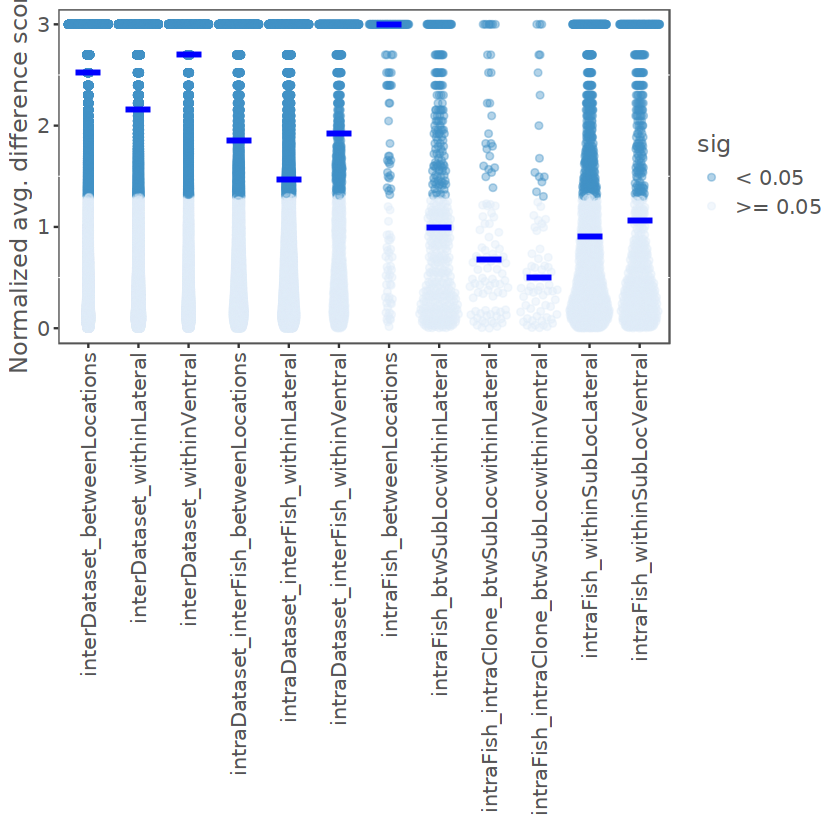

In [202]:
# Plot p-values
ggplot(results_df_p_all_plot, aes(x = type_comp, y = neglog10pval)) +
            geom_quasirandom(aes(color = sig, group = 1),alpha = 0.4,dodge.width = 0.5) +
            scale_color_manual(values = c('#4292C6','#DEEBF7')) +
            stat_summary(fun = median, geom = "crossbar",
                         width = .5, color = "blue") +
            labs(x = '', y = 'Normalized avg. difference score') +
            mytheme_angledX

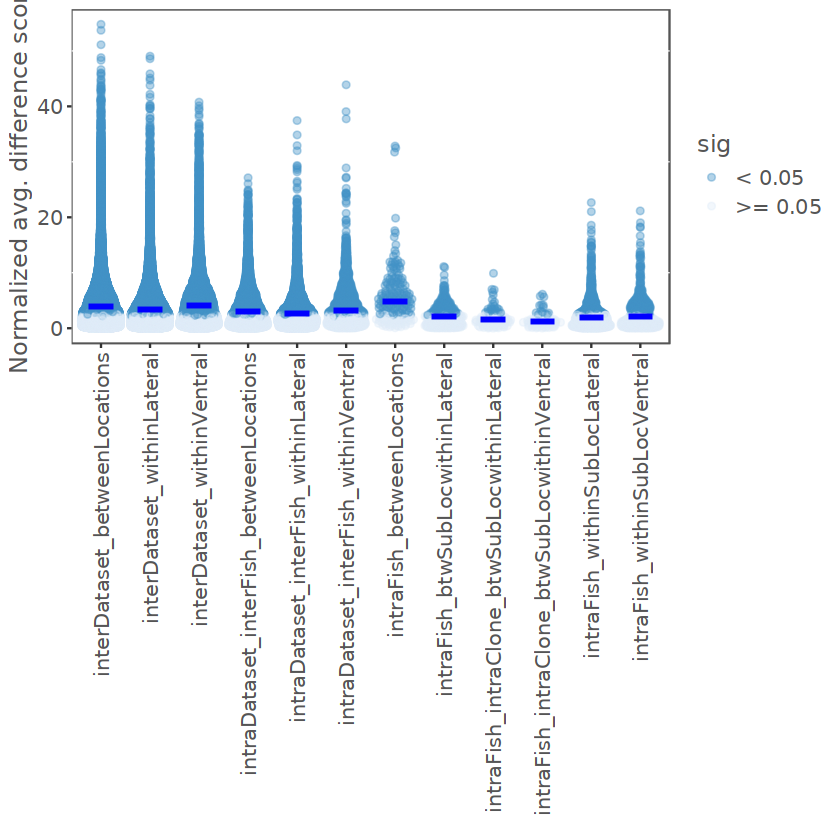

In [203]:
# Plot normalized differential expression score
ggplot(results_df_p_all_plot, aes(x = type_comp, y = diff)) +
            geom_quasirandom(aes(color = sig, group = 1),alpha = 0.4,dodge.width = 0.5) +
            scale_color_manual(values = c('#4292C6','#DEEBF7')) +
            stat_summary(fun = median, geom = "crossbar",
                         width = .5, color = "blue") +
            labs(x = '', y = 'Normalized avg. difference score') +
            mytheme_angledX

#### Plot results for clone pairs found in same tumor sub-location only

##### p-values

In [204]:
## Add a column for the average pct expressed in both clones
results_df_p_all_ann$pct_expr_clone_mean <- (results_df_p_all_ann$pct_expr_clone1 + results_df_p_all_ann$pct_expr_clone2)/2

## Module sets
set_1 <- unique(results_df_p_all_ann$Module_trans)

In [205]:
# SET SUBSET TO PLOT HERE - we only take comparisons within a single fish and within a sublocation
dataset_type <- c('intraFish')
set <- set_1
set_name <- 'Set_1'

type_name <- paste(type, collapse = '_')
results_df_p_all_plot <- results_df_p_all_ann[results_df_p_all_ann$type %in% dataset_type,]
results_df_p_all_plot <- results_df_p_all_plot[results_df_p_all_plot$location_comp %in% c('withinSubLocLateral', 'withinSubLocVentral'),]
results_df_p_all_plot <- results_df_p_all_plot[results_df_p_all_plot$Module_trans %in% set,]


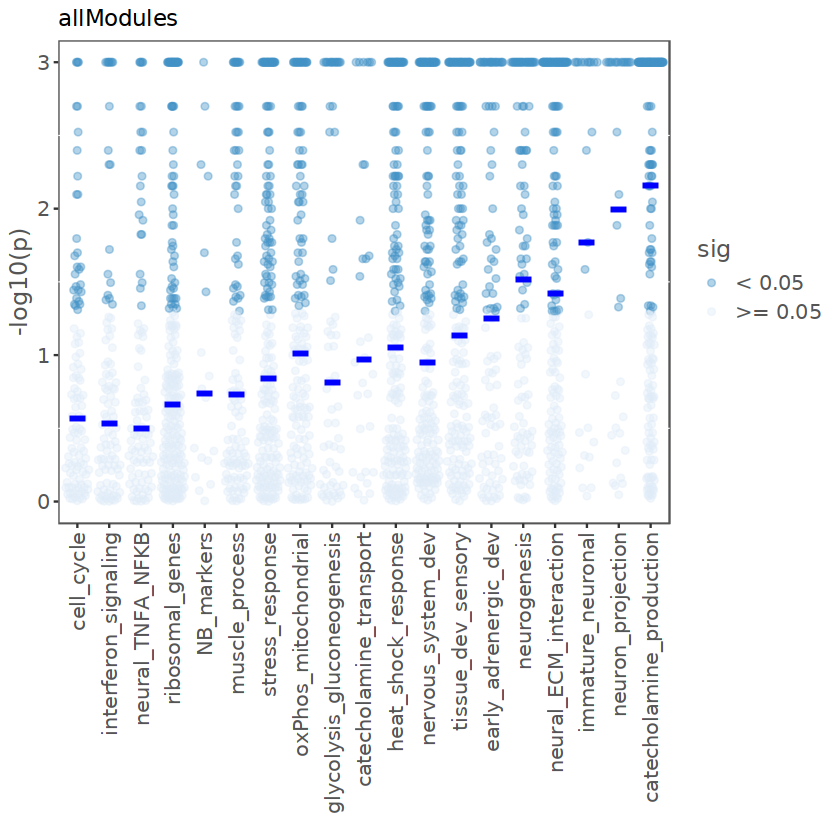

In [206]:
results_df_p_all_plot <- results_df_p_all_plot %>% mutate(Module_short = fct_reorder(Module_short, neglog10pval, .fun='mean'))

ggplot(results_df_p_all_plot, aes(x = Module_short, y = neglog10pval)) +
            geom_quasirandom(aes(color = sig, group = 1),alpha = 0.4,dodge.width = 0.4) +
            scale_color_manual(values = c('#4292C6','#DEEBF7')) +
            stat_summary(fun = median, geom = "crossbar",
                         width = 0.5, color = "blue") +
            labs(title = 'allModules', x = '', y = '-log10(p)') +
            mytheme_angledX

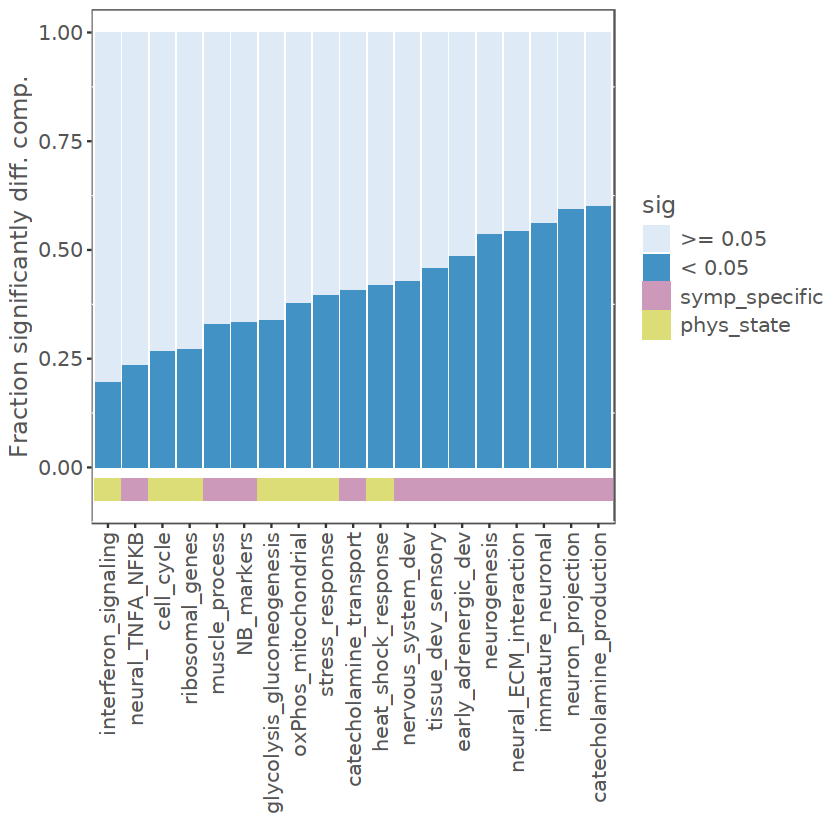

In [207]:
# Plot fraction significant / non-significant bar plots

test <- as.data.frame(table(results_df_p_all_plot$Module_short, results_df_p_all_plot$sig))
colnames(test) <- c('Module_trans', 'sig','fraction')
test <- test[with(test, order(sig, fraction)), ]

# Calculate the total fraction for each module
test <- test %>%
  group_by(Module_trans) %>%
  mutate(total_fraction = sum(fraction)) %>%
  ungroup()

# Calculate the fraction of each fraction value per sig value for each module
test <- test %>%
  mutate(fraction_of_total = fraction / total_fraction)

test <- left_join(test, mod_type_vals, by = 'Module_trans')

test$sig <- factor(as.character(test$sig), levels = c('>= 0.05','< 0.05'))
test <- test[with(test, order(sig,fraction_of_total)), ]
test$Module_trans <- factor(as.character(test$Module_trans), levels = rev(unique(test$Module_trans)))

test$type <- factor(as.character(test$type), levels = c('symp_specific','phys_state'))


ggplot(test, aes(fill=sig, y=fraction, x=Module_trans)) + 
            geom_bar(position="fill", stat="identity") +
            scale_fill_manual(values = c("#DEEBF7","#4292C6",'#CC99BB','#DDDD77')) +
            labs(x = '', y = 'Fraction significantly diff. comp.') +
            geom_tile(aes(x=Module_trans, y=-0.05, fill=type), height=0.05) +
            mytheme_angledX


##### average difference scores

In [208]:
# Set subset to plot here
type <- c('intraFish', 'intraDataset_interFish','interDataset')
set <- set_1
set_name <- 'Set_1'

type_name <- paste(type, collapse = '_')

results_df_p_all_plot <- results_df_p_all_ann[results_df_p_all_ann$type %in% dataset_type,]
results_df_p_all_plot <- results_df_p_all_plot[results_df_p_all_plot$location_comp %in% c('withinSubLocLateral', 'withinSubLocVentral'),]
results_df_p_all_plot <- results_df_p_all_plot[results_df_p_all_plot$Module_trans %in% set,]

results_df_p_all_plot$diff <- results_df_p_all_plot$avg_diff_actual / results_df_p_all_plot$avg_diff_perm_mean
results_df_p_all_plot$diff[results_df_p_all_plot$avg_diff_actual == 0 | results_df_p_all_plot$avg_diff_perm_mean == 0] <- 0


In [209]:
# save median and mean difference scores
results_df_p_all_short <- results_df_p_all_plot[,c('Module_short','diff')]

df_median <- results_df_p_all_short %>%
  group_by(Module_short) %>%
  summarise(median_diff = median(diff))

df_mean <- results_df_p_all_short %>%
  group_by(Module_short) %>%
  summarise(mean_diff = mean(diff))


df_stats <- left_join(df_median,df_mean, by = 'Module_short')

write.csv(df_stats, paste0('mean_and_median_interClon_diffScores_',score_type,'_',filt_name,'.csv'), quote = F)

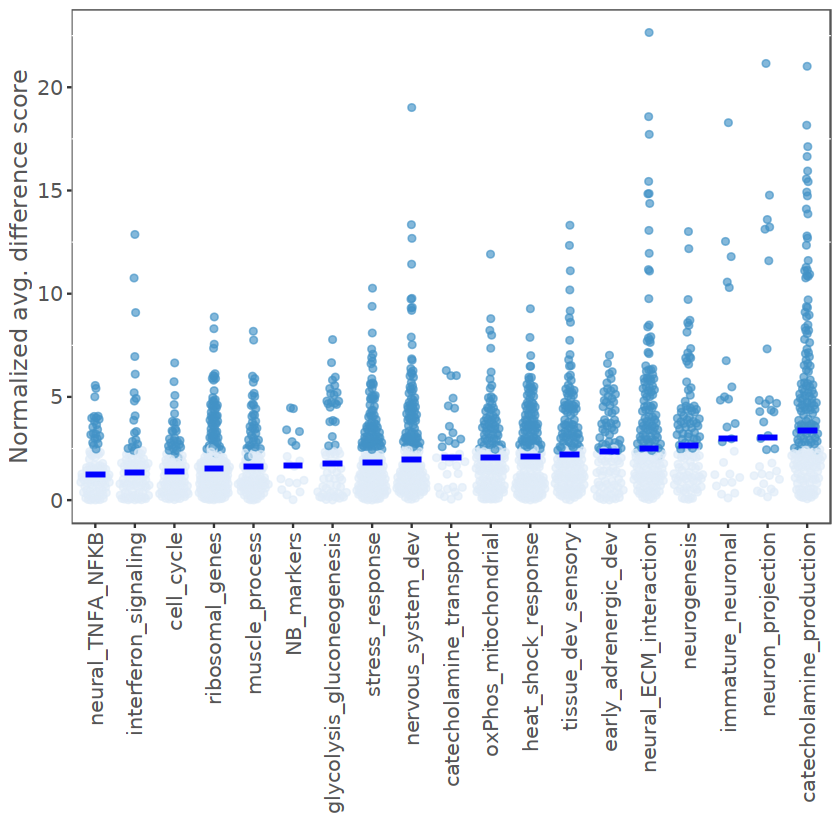

In [210]:
# Plot
results_df_p_all_plot <- results_df_p_all_plot %>% mutate(Module_short = fct_reorder(Module_short, neglog10pval, .fun='median'))

ggplot(results_df_p_all_plot, aes(x = Module_short, y = diff)) +
        geom_quasirandom(aes(color = sig, group = 1),alpha = 0.65,dodge.width = 0.4) +
        scale_color_manual(values = c('#4292C6','#DEEBF7')) +
        stat_summary(fun = median, geom = "crossbar",
                         width = .5, color = "blue") +
        labs(x = '', y = 'Normalized avg. difference score') +
        theme(legend.position = 'none') +
        mytheme_angledX

##### Plot expression distribution for selected clone pairs

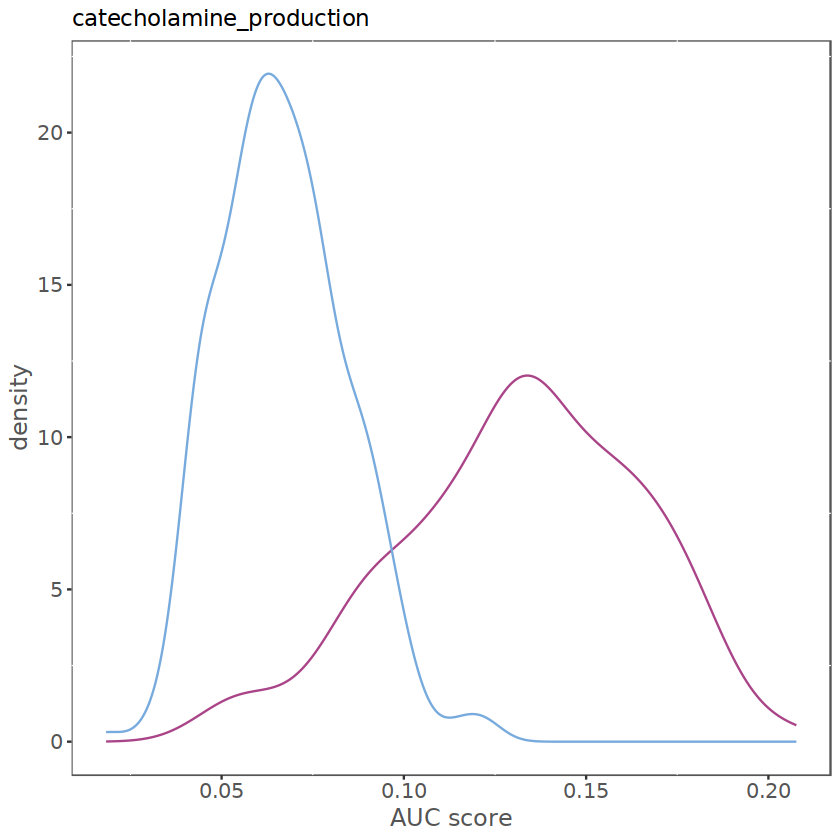

In [213]:

# Example 01
mod <- 'catecholamine_production'
clone_1 <- 'multi_seq_17_fish_5_clone_5_28_tum_5_1'
clone_2 <- 'multi_seq_17_fish_5_clone_5_1_tum_5_1'

# Example 02
#mod <- 'immature_neuronal'
#clone_1 <- 'multi_seq_05_fish_3_clone_3_4_tum_3'
#clone_2 <- 'multi_seq_05_fish_3_clone_3_5_tum_3'

# Example 03
#mod <- 'neural_ECM_interaction'
#clone_1 <- 'multi_seq_17_fish_2_clone_2_8_tum_2_1'
#clone_2 <- 'multi_seq_17_fish_2_clone_2_23_tum_2_1'

# Example 04
#mod <- 'neuron_diff'
#clone_1 <- 'multi_seq_09_fish_1_clone_1_11_tum_1'
#clone_2 <- 'multi_seq_09_fish_1_clone_1_5_tum_1'

# Example 05
#mod <- 'neural_ECM_interaction'
#clone_1 <- 'multi_seq_05_fish_3_clone_3_4_tum_3'
#clone_2 <- 'multi_seq_05_fish_3_clone_3_5_tum_3'

# Add ID to module number depending on assay used
if(score_type == 'barkley'){
    mod_plot <- paste0('bark_',mod)

}else if(score_type == 'auc'){
    mod_plot <- paste0('auc_',mod)
          
}else if(score_type == 'count'){
    mod_plot <- paste0('counts_',mod)
        
}
    
   
sub_int <- dat@meta.data[dat@meta.data$location_clones %in% c(clone_1, clone_2),]

sub_int_plot <- sub_int
colnames(sub_int_plot)[grep(mod_plot, colnames(sub_int_plot))] <- 'mod_plot'

ggplot(sub_int_plot, aes(x = mod_plot, group = location_clones, col = location_clones)) +
        #   geom_density(aes(y = after_stat(density * n/nrow(sub_int_plot)))) +
        geom_density() +
        scale_color_manual(values = c(tol21rainbow[2],tol21rainbow[6]), guide = 'none') +
        labs(x = 'AUC score', y = 'density', title = paste0(mod)) +
        mytheme_basic


#### Plot results for groups of cells from the same clone found in different tumor sub-locations

In [216]:
## Add a column for the average pct expressed in both clones
results_df_p_all_ann$pct_expr_clone_mean <- (results_df_p_all_ann$pct_expr_clone1 + results_df_p_all_ann$pct_expr_clone2)/2

## Module sets
set_1 <- unique(results_df_p_all_ann$Module_trans)

##### p-values

In [217]:
# SET SUBSET TO PLOT HERE - we only take comparisons within a single fish and within a sublocation
dataset_type <- c('intraFish')
set <- set_1
set_name <- 'Set_1'

type_name <- paste(type, collapse = '_')

results_df_p_all_plot <- results_df_p_all_ann[results_df_p_all_ann$type %in% dataset_type,]
results_df_p_all_plot <- results_df_p_all_plot[results_df_p_all_plot$location_comp %in% c('intraClone_btwSubLocwithinVentral', 'intraClone_btwSubLocwithinLateral'),]
results_df_p_all_plot <- results_df_p_all_plot[results_df_p_all_plot$Module_trans %in% set,]


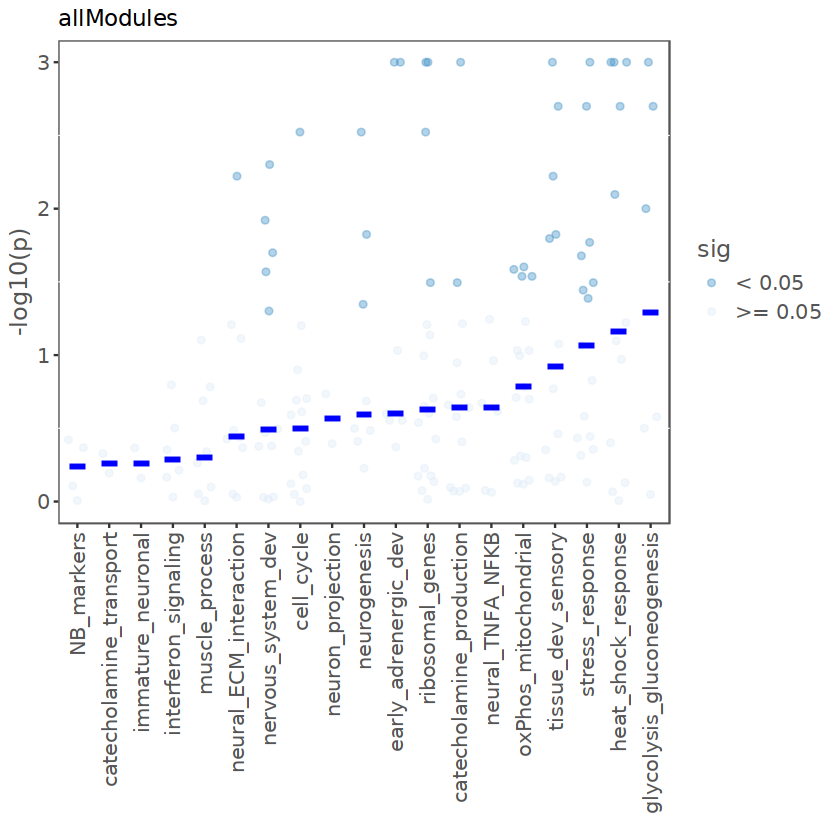

In [218]:
results_df_p_all_plot <- results_df_p_all_plot %>% mutate(Module_short = fct_reorder(Module_short, neglog10pval, .fun='median'))

ggplot(results_df_p_all_plot, aes(x = Module_short, y = neglog10pval)) +
        geom_quasirandom(aes(color = sig, group = 1),alpha = 0.4,dodge.width = 0.4) +
        scale_color_manual(values = c('#4292C6','#DEEBF7')) +
        stat_summary(fun = median, geom = "crossbar",
                         width = 0.5, color = "blue") +
        labs(title = 'allModules', x = '', y = '-log10(p)') +
        mytheme_angledX

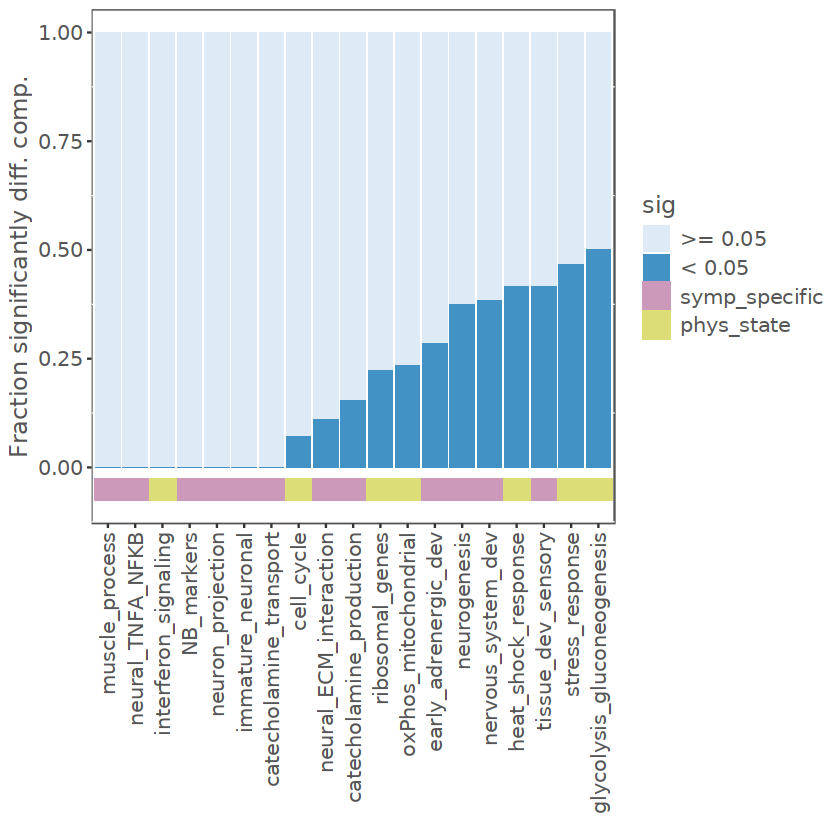

In [219]:
# Plot fraction significant / non-significant bar plots

test <- as.data.frame(table(results_df_p_all_plot$Module_short, results_df_p_all_plot$sig))
colnames(test) <- c('Module_trans', 'sig','fraction')
#test <- test[order(test$fraction, decreasing = T),]
test <- test[with(test, order(sig, fraction)), ]

# Calculate the total fraction for each module
test <- test %>%
  group_by(Module_trans) %>%
  mutate(total_fraction = sum(fraction)) %>%
  ungroup()

# Calculate the fraction of each fraction value per sig value for each module
test <- test %>%
  mutate(fraction_of_total = fraction / total_fraction)

test <- left_join(test, mod_type_vals, by = 'Module_trans')

test$sig <- factor(as.character(test$sig), levels = c('>= 0.05','< 0.05'))
test <- test[with(test, order(sig,fraction_of_total)), ]
test$Module_trans <- factor(as.character(test$Module_trans), levels = rev(unique(test$Module_trans)))

test$type <- factor(as.character(test$type), levels = c('symp_specific','phys_state'))

ggplot(test, aes(fill=sig, y=fraction, x=Module_trans)) + 
        geom_bar(position="fill", stat="identity") +
        scale_fill_manual(values = c("#DEEBF7", "#4292C6",'#CC99BB','#DDDD77')) +
        labs(x = '', y = 'Fraction significantly diff. comp.') +
        geom_tile(aes(x=Module_trans, y=-0.05, fill=type), height=0.05) +
        mytheme_angledX

##### average difference scores

In [220]:
# SET SUBSET TO PLOT HERE - we only take comparisons within a single fish and within a sublocation
dataset_type <- c('intraFish')
set <- set_1
set_name <- 'Set_1'


type_name <- paste(type, collapse = '_')

results_df_p_all_plot <- results_df_p_all_ann[results_df_p_all_ann$type %in% dataset_type,]
results_df_p_all_plot <- results_df_p_all_plot[results_df_p_all_plot$location_comp %in% c('intraClone_btwSubLocwithinVentral', 'intraClone_btwSubLocwithinLateral'),]
results_df_p_all_plot <- results_df_p_all_plot[results_df_p_all_plot$Module_trans %in% set,]

results_df_p_all_plot$diff <- results_df_p_all_plot$avg_diff_actual / results_df_p_all_plot$avg_diff_perm_mean
results_df_p_all_plot$diff[results_df_p_all_plot$avg_diff_actual == 0 | results_df_p_all_plot$avg_diff_perm_mean == 0] <- 0


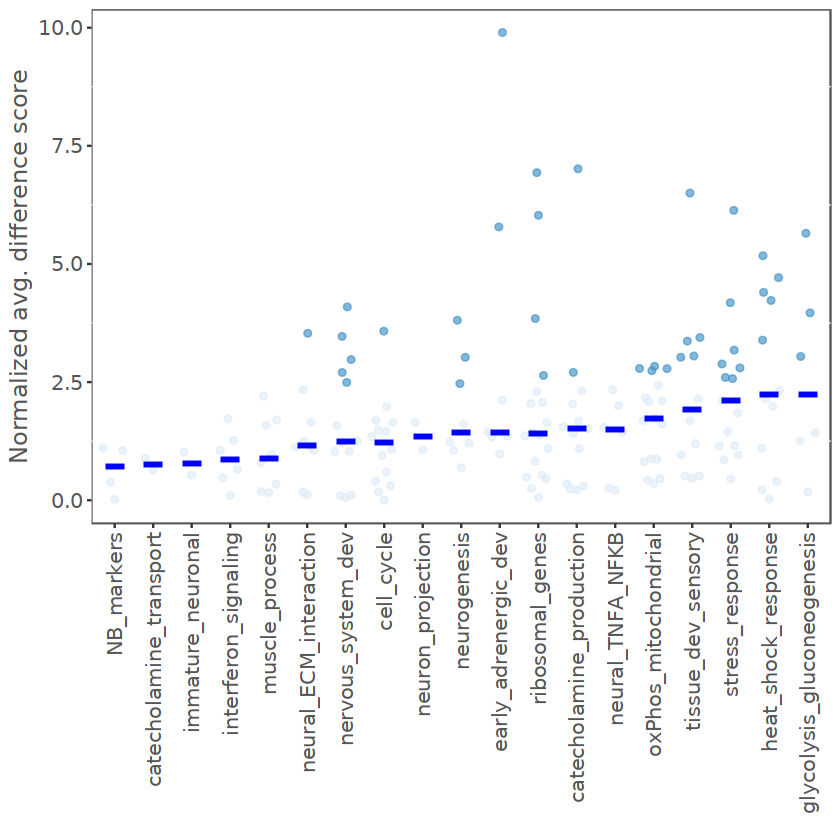

In [221]:

results_df_p_all_plot <- results_df_p_all_plot %>% mutate(Module_short = fct_reorder(Module_short, neglog10pval, .fun='median'))

ggplot(results_df_p_all_plot, aes(x = Module_short, y = diff)) +
            geom_quasirandom(aes(color = sig, group = 1),alpha = 0.65,dodge.width = 0.4) +
            scale_color_manual(values = c('#4292C6','#DEEBF7')) +
            stat_summary(fun = median, geom = "crossbar",
                         width = .5, color = "blue") +
            labs(x = '', y = 'Normalized avg. difference score') +
            theme(legend.position = 'none') +
            mytheme_angledX


##### Plot expression distribution for selected intra-clone location pairs

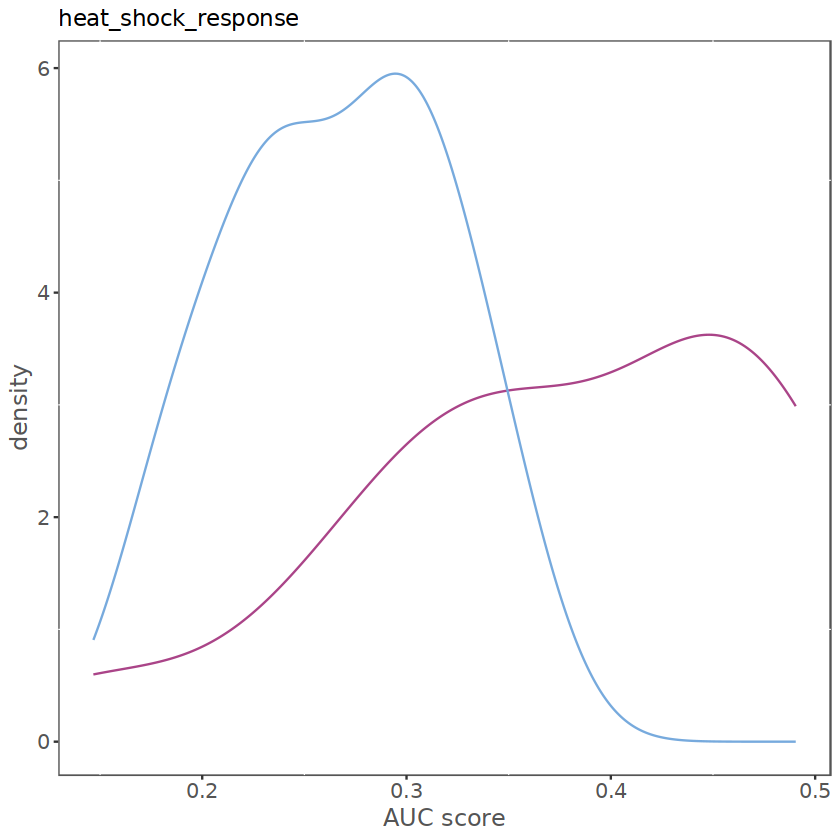

In [222]:
# Example 01
mod <- 'heat_shock_response'
clone_1 <- 'multi_seq_09_fish_5_clone_5_1_tum_5_1'
clone_2 <- 'multi_seq_09_fish_5_clone_5_1_tum_5_2'

# Example 02
#mod <- 'stress_response'
#clone_1 <- 'multi_seq_09_fish_5_clone_5_27_tum_5_1'
#clone_2 <- 'multi_seq_09_fish_5_clone_5_27_tum_5_2'

# Example 03
#mod <- 'catecholamine_production'
#clone_1 <- 'multi_seq_09_fish_3_clone_3_5_tum_3_1'
#clone_2 <- 'multi_seq_09_fish_3_clone_3_5_tum_3_2'

# Example 04
#mod <- 'catecholamine_production'
#clone_1 <- 'multi_seq_09_fish_3_clone_3_5_tum_3_1'
#clone_2 <- 'multi_seq_09_fish_3_clone_3_5_tum_3_2'


# Add ID to module number depending on assay used
if(score_type == 'barkley'){
    mod_plot <- paste0('bark_',mod)

}else if(score_type == 'auc'){
    mod_plot <- paste0('auc_',mod)
    
}else if(score_type == 'count'){
    mod_plot <- paste0('counts_',mod)
        
}
    
   
sub_int <- dat@meta.data[dat@meta.data$location_clones %in% c(clone_1, clone_2),]

sub_int_plot <- sub_int
colnames(sub_int_plot)[grep(mod_plot, colnames(sub_int_plot))] <- 'mod_plot'


ggplot(sub_int_plot, aes(x = mod_plot, group = location_clones, col = location_clones)) +
        #   geom_density(aes(y = after_stat(density * n/nrow(sub_int_plot)))) +
            geom_density() +
            scale_color_manual(values = c(tol21rainbow[2],tol21rainbow[6]), guide = 'none') +
            labs(x = 'AUC score', y = 'density', title = paste0(mod)) +
            mytheme_basic


## Calculate gene module expression variance

### Reload and prepare data

In [3]:
# Load Seurat metadata with high-resolution clone assignments and module scores
dat <- readRDS(paste0('data/seur_obj_NBcells_with_clones_and_scores_DR_NB_modules_',dat_name,'.rds'))

# Remove cells that have not been assigned to a clone
cells_keep <- rownames(dat@meta.data[!is.na(dat@meta.data$fish_clone),])
dim(dat)

dat <- subset(dat, cells = cells_keep)
dim(dat)

[1] 26275 62886

[1] 26275 23824

In [9]:
# Get order of modules in data
mod_order <- read.delim('data/mod_name_order_in_data.csv', sep = ',', stringsAsFactors = F, header = T, row.names = 1)

mod_order <- mod_order$x

module_metnames <- mod_order

In [8]:
# Load final module table
modules_pan <- read.delim('../gene_modules/final_gene_modules_list.csv', sep = ',', stringsAsFactors = F, header = T)

# Re-format into list
modules_pan <- as.list(modules_pan)

# Double-check that common gene names contain correct set of special characters
modules_pan <- lapply(modules_pan, function(x) gsub("si\\.","si:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("zgc\\.","zgc:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("mt\\.","mt-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("dkey\\.","dkey-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("h211\\.","h211-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("ch73\\.","ch73-",x))

# Remove empty entries
modules_pan <- lapply(modules_pan, function(x) {
  # Remove NA and empty string "" entries
  x[!(is.na(x) | x == "")]
})

# Remove modules that are too short
modules_pan <- modules_pan[lengths(modules_pan) > 5]

In [10]:
# Create assay for the counts-based gene module expression scores
summed_assay <- CreateAssayObject(counts = t(Embeddings(dat, reduction = "scores_count")))

dat[["assay_count"]] <- summed_assay

# Create assay for  counts-based gene module expression scores together with all individual genes
gene_counts <- as.data.frame(t(as.matrix(GetAssayData(dat, slot = 'counts'))))
summed_assay <- as.data.frame(Embeddings(dat, reduction = "scores_count"))

gene_counts$cell <- rownames(gene_counts)
summed_assay$cell <- rownames(summed_assay)

gene_plus_mod_counts <- left_join(gene_counts, summed_assay, by = 'cell')
rownames(gene_plus_mod_counts) <- gene_plus_mod_counts$cell
gene_plus_mod_counts$cell <- NULL

table(rownames(gene_plus_mod_counts) == rownames(gene_counts))

gene_plus_mod_counts <- as(t(as.matrix(gene_plus_mod_counts)), "dgCMatrix")
summed_assay <- CreateAssayObject(counts = gene_plus_mod_counts)

dat[["assay_count_with_genes_logNorm"]] <- summed_assay

# Log-normalize the counts-based scores
# Make your custom assay the default (optional but convenient)
DefaultAssay(dat) <- "assay_count_with_genes_logNorm"

# Log-normalize this assay
dat <- NormalizeData(
  object = dat,
  assay  = "assay_count_with_genes_logNorm",
  normalization.method = "LogNormalize"
)


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from assay_count_ to assaycount_”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.7 GiB”



 TRUE 
23824 

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from assay_count_with_genes_lognorm_ to assaycountwithgeneslognorm_”


### Calculate overall module expression variance in all NB cells

In [252]:
# set type of score to use
type <- 'count_with_genes_logNorm'

# Make sure that the log-normalized values are called by explicitly giving them to FindVariableFeatures
mat_norm <- GetAssayData(dat, assay = "assay_count_with_genes_logNorm", slot = "data")
# Seurat's internal FindVariableFeatures function is not exported; call with triple-colon:
vst_out_norm <- Seurat:::FindVariableFeatures(mat_norm, selection.method = "vst")

# Save results in variable
variable_features <- vst_out_norm


Warning message:
“The following arguments are not used: nfeatures”


In [253]:
# Rename modules
orthos_vec <- module_metnames

# Add ID to module number depending on assay used
genes <- rownames(variable_features)
genes <- genes[!genes %like any% 'count-%']
orthos_vec <- c(orthos_vec, genes)
names(orthos_vec) <- c(paste0('count-',c(1:length(module_metnames))),genes)

orthos_vec <- orthos_vec[orthos_vec %in%  names(modules_pan)]

variable_features$mod_name <- revalue(rownames(variable_features), orthos_vec, warn_missing = T)

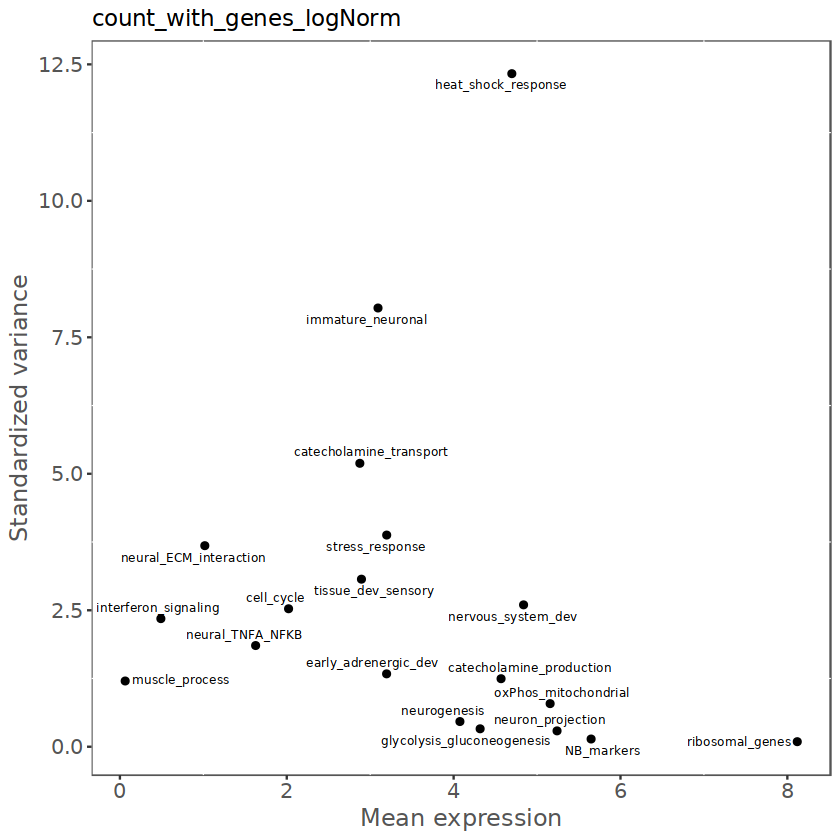

In [254]:
variable_features <- variable_features[!variable_features$mod_name %like any% 'count-%',]
variable_features$module <- 'yes'
variable_features$module[is.na(variable_features$mod_name)] <- 'no'
variable_features <- variable_features[rownames(variable_features) %like any% 'count-%',]

print(
    ggplot(variable_features, aes(x = vst.mean, y = vst.variance.standardized)) +
        geom_point() +
        scale_color_manual(values = c('dark grey','dark red')) +
        geom_text_repel(aes(label = mod_name), size = 2.5, max.overlaps = 30, box.padding = unit(0.2, "lines")) +
        labs(title = type, x = 'Mean expression', y = 'Standardized variance') +
        theme(legend.position="none") +
        mytheme_basic
)

### Calculate module expression variance in individual clones

In [257]:
all_samples <- unique(dat@meta.data$fish_clone)

type <- 'count_with_genes_logNorm'

Idents(dat) <- 'fish_clone'

perTumVar <- data.frame()


for(i in 1:length(all_samples)){

    sample_i <- all_samples[i]
    sub_dat <- subset(dat, idents = sample_i)

    if(ncol(sub_dat) <= 30){
        print(paste0('Dataset ', sample_i, ' is too small.'))
        next
    }

    # Calculate vst and mean for a given score type
    mat_norm <- GetAssayData(sub_dat, assay = "assay_count_with_genes_logNorm", slot = "data")
    # Seurat's internal FindVariableFeatures function is not exported; call with triple-colon:
    variable_features <- Seurat:::FindVariableFeatures(mat_norm, selection.method = "vst")
    variable_features <- variable_features[rownames(variable_features) %like any% 'count-%',]
        
    variable_features$mod <- rownames(variable_features)
    variable_features$sample_all <- sample_i

    perTumVar <- rbind(perTumVar, variable_features)
    
}

write.csv(perTumVar, paste0('data/module_variance_measures_per_clone_scoreType_',type,'_',dat_name,'.csv'))

[1] "Dataset multi_seq_02_fish_1_clone_1_2 is too small."
[1] "Dataset multi_seq_02_fish_5_clone_5_3 is too small."
[1] "Dataset multi_seq_02_fish_1_clone_1_5 is too small."
[1] "Dataset multi_seq_02_fish_3_clone_3_2 is too small."
[1] "Dataset multi_seq_02_fish_1_clone_1_3 is too small."
[1] "Dataset multi_seq_02_fish_2_clone_2_1 is too small."
[1] "Dataset multi_seq_02_fish_4_clone_4_15 is too small."
[1] "Dataset multi_seq_02_fish_2_clone_2_2 is too small."
[1] "Dataset multi_seq_02_fish_4_clone_4_8 is too small."
[1] "Dataset multi_seq_02_fish_2_clone_2_3 is too small."
[1] "Dataset multi_seq_02_fish_4_clone_4_14 is too small."
[1] "Dataset multi_seq_02_fish_5_clone_5_4 is too small."
[1] "Dataset multi_seq_02_fish_5_clone_5_1 is too small."
[1] "Dataset multi_seq_02_fish_1_clone_1_4 is too small."
[1] "Dataset multi_seq_02_fish_4_clone_4_2 is too small."
[1] "Dataset multi_seq_02_fish_4_clone_4_4 is too small."
[1] "Dataset multi_seq_02_fish_1_clone_1_6 is too small."
[1] "Dataset

#### Reload and plot

In [12]:
type <- 'count_with_genes_logNorm'
perTumVar <- read.delim(paste0('data/module_variance_measures_per_clone_scoreType_',type,'_',dat_name,'.csv'), sep = ',', stringsAsFactors = F, row.names = 1)

b1 <- 1
b2 <- 30

module_names <- data.frame(matrix(,nrow=b2,ncol=0))
module_names$mod <- paste0('count-',c(b1:b2))
module_names$mod_name <- module_metnames

perTumVar <- left_join(perTumVar, module_names, by = 'mod')
perTumVar <- perTumVar[perTumVar$mod_name %in% names(modules_pan),]


In [13]:
# Filter: Set minimum fraction of cells of a clone in which a module has to be activated to keep comparison.
# This is typically set to 0.05, i.e. 5 % of cells in a clone need to show expression of the module.
# Expression fraction is always based on 'Barkley' scores. Therefore, load expression stats generated from this type of score.

filt_type <- '0.05'

# Filter if desired
dim(perTumVar)
if(filt_type == 'all'){
    
    perTumVar_plot <- perTumVar
    
}else{

    stats_df <- read.delim('data/expr_stats_individualClones.csv', sep = ',', header = T, row.names = 1)

    stats_df$Clone <- sapply(strsplit(stats_df$Clone,"_tum"), `[`, 1)

    stats_df$clone_mod <- paste0(stats_df$Clone, '_','count','-', gsub('bark_','',stats_df$Module))
    stats_df <- stats_df[!duplicated(stats_df$clone_mod),]
    stats_df <- stats_df[stats_df$pct_expr_clone >= filt_type,]

    perTumVar$clone_mod <- paste0(perTumVar$sample_all,'_', perTumVar$mod)
    perTumVar_plot <- perTumVar[perTumVar$clone_mod %in% stats_df$clone_mod,]
}

dim(perTumVar_plot)

perTumVar_plot <- perTumVar_plot[!is.na(perTumVar_plot$vst.variance.standardized),]


write.csv(perTumVar_plot,paste0('./data/module_variance_measures_per_clone_scoreType_',type,"_",dat_name,'_filtered_',filt_type,'.csv'))


[1] 1596    7

[1] 631   8

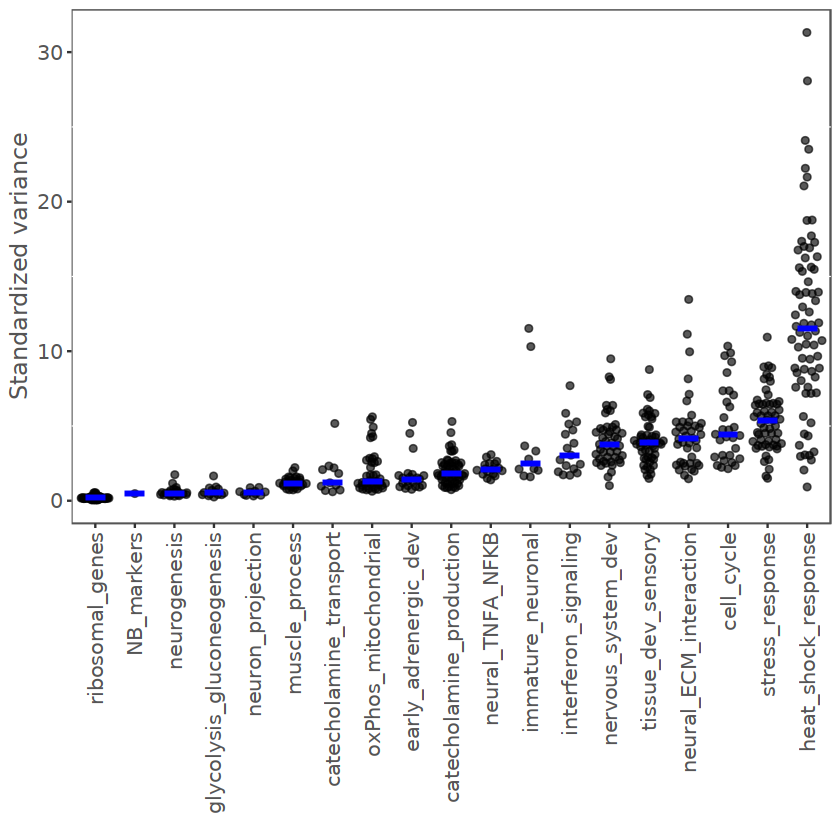

In [337]:
# Reload and plot

type <- 'count_with_genes_logNorm'
perTumVar_plot <- read.delim(paste0('./data/module_variance_measures_per_clone_scoreType_',type,"_",dat_name,'_filtered_',filt_type,'.csv'), sep = ',', stringsAsFactors = F, row.names = 1)

perTumVar_plot <- perTumVar_plot %>% mutate(mod_name = fct_reorder(mod_name, vst.variance.standardized, .fun='median'))

print(
    ggplot(perTumVar_plot, aes(x = mod_name, y = vst.variance.standardized)) +
            geom_quasirandom(alpha = 0.65,dodge.width = 0.4) +
            stat_summary(fun = median, geom = "crossbar",
                         width = .5, color = "blue") +
            labs(x = '', y = 'Standardized variance') +
            mytheme_angledX
)

#### Plot intra-clone variance against median diff expression between clones

In [338]:
# Reload diff expression stats for modules
diff_type <- 'auc'
filt_name <- 'comps_over_5_pct'

diff_sores <- read.delim(paste0('data/mean_and_median_interClon_diffScores_',diff_type,'_',filt_name,'.csv'), sep = ',', stringsAsFactors = F, row.names = 1)



In [339]:
# save median and mean difference scores
perTumVar_short <- perTumVar_plot[,c('mod_name','vst.variance.standardized')]

df_median <- perTumVar_short %>%
  group_by(mod_name) %>%
  summarise(median_var = median(vst.variance.standardized))

df_mean <- perTumVar_short %>%
  group_by(mod_name) %>%
  summarise(mean_var = mean(vst.variance.standardized))


df_stats <- left_join(df_median,df_mean, by = 'mod_name')
colnames(df_stats) <- c('Module_short','median_var','mean_var')

In [340]:
df_allStats <- left_join(df_stats,diff_sores, by =  'Module_short')


     both_low symp_specific    phys_state 
           10             5             4 

Warning message in geom_label_repel(aes(label = Module_some), size = 3.5, label.size = 0.01, :
“Ignoring unknown parameters: `linewidth`”
Warning message in geom_label_repel(aes(label = Module_some), size = 3.5, label.size = 0.01, :
“Ignoring unknown parameters: `linewidth`”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range (`geom_label_repel()`).”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range (`geom_label_repel()`).”


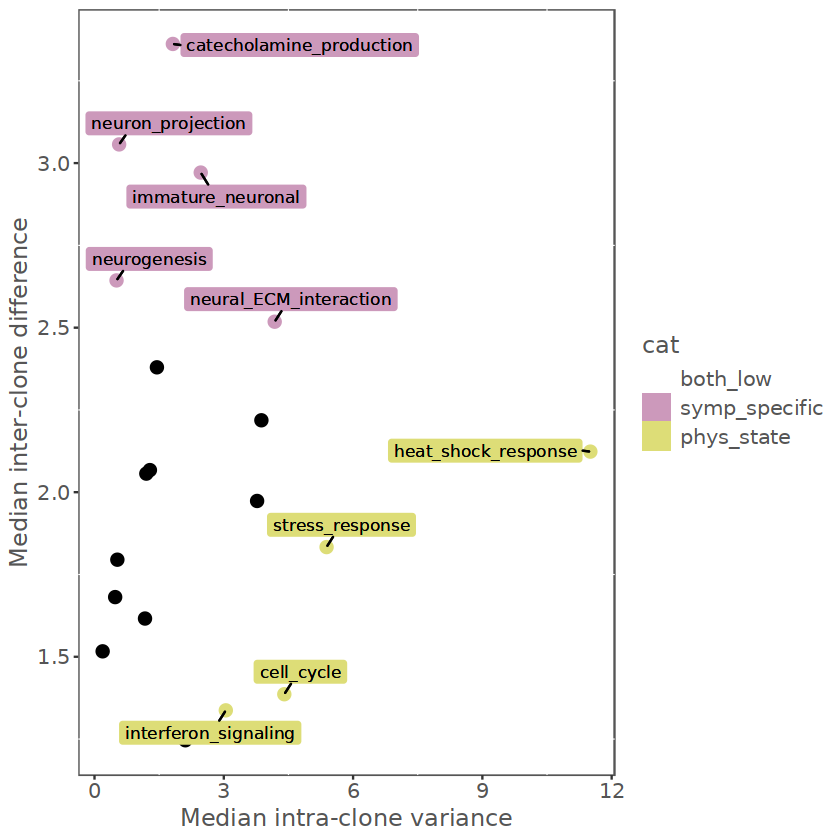

In [341]:
# with chosen labels
df_allStats$cat <- 'both_low'
df_allStats$Module_some <- NA
df_allStats <- df_allStats[order(df_allStats$median_diff, decreasing = T),]
df_allStats$cat[1:5] <- 'symp_specific'
df_allStats$Module_some <- df_allStats$Module_short
df_allStats$cat[df_allStats$Module_short %in% c('cell_cycle','stress_response','interferon_signaling','heat_shock_response')] <- 'phys_state'
df_allStats$Module_some[df_allStats$cat == 'both_low'] <- NA
df_allStats$Module_some[df_allStats$cat == 'both_low'] <- NA

df_allStats$cat <- factor(as.character(df_allStats$cat), levels = c('both_low','symp_specific','phys_state'))
table(df_allStats$cat )

ggplot(df_allStats, aes(x = median_var, y = median_diff, col = cat, fill = cat)) +
        geom_point(size = 3) +
        geom_label_repel(aes(label = Module_some), size = 3.5, label.size = 0.01, linewidth = 0.1,
                            max.overlaps = 50, box.padding = 0.3, point.padding = 0, color = 'black',
                            force = 20, min.segment.length = 0, alpha = 1, seed = 123) +
        geom_label_repel(aes(label = Module_some), size = 3.5, label.size = 0.01, linewidth = 0.1,
                            max.overlaps = 50, box.padding = 0.3, point.padding = 0, color = 'black',
                            force = 20, min.segment.length = 0, fill = NA, seed = 123) +
        scale_color_manual(values = c('black','#CC99BB','#DDDD77')) +
        scale_fill_manual(values = c('#FFFFFF80','#CC99BB80','#DDDD7780')) +
        labs(x = 'Median intra-clone variance', y = 'Median inter-clone difference') +
        guides(fill = guide_legend(override.aes = aes(color = NA))) +
        mytheme_basic
